# Sprint 機械学習フロー

【問題1】クロスバリデーション

参考サイト:<br>
LightGBMでのクロスバリデーション実装<br>
https://potesara-tips.com/lightgbm-k-fold-cross-validation/<br>
scikit-learn を用いた交差検証（Cross-validation）とハイパーパラメータのチューニング（grid search)<br>
https://qiita.com/tomov3/items/039d4271ed30490edf7b<br>

In [13]:
# 必要なデータ読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
from datetime import datetime 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib.gridspec as gridspec


%matplotlib inline
# import sys
# sys.path
DIR_PATH = '/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/python/week3/Home_credit_Default_Risk/'


train = pd.read_csv(DIR_PATH+'application_train.csv')
test = pd.read_csv(DIR_PATH+'application_test.csv')
test_id = test['SK_ID_CURR']
pd.set_option('display.max_columns', train.shape[1])
pd.set_option('display.max_rows', 100)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# ここからnull importance

In [195]:
categorical_feat = [f for f in train.columns if train[f].dtype == 'object']
for f_ in categorical_feat:
    # labels, unique = pd.factorize(train[f_]): f_のカテゴリーデータをlabel encodingしてくれる
    train[f_], _ = pd.factorize(train[f_])
    # categoryタイプをセット
    train[f_] = train[f_].astype('category')

In [211]:
def get_feature_importance(data, shuffle, seed=None):
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    y = data['TARGET'].copy()
    if shuffle:
        y = data['TARGET'].copy().sample(frac=1.0)
        
    # lightgbmでfitさせる
    lgbm_train = lgbm.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    model = lgbm.train(lgb_params, train_set=lgbm_train, num_boost_round=200, categorical_feature=categorical_feats)
    
    imp_df = pd.DataFrame()
    imp_df['features'] = list(train_features)
    imp_df['imporance_gain'] = model.feature_importance(importance_type='gain')
    imp_df['importance_split'] = model.feature_importance(importance_type='split')
    # これdata[train_features]でええのか？train_test_splitせんでもええのか？
    imp_df['trn_score'] = roc_auc_score(y, model.predict(data[train_features]))
    
    return imp_df

In [212]:
np.random.seed(123)
actual_imp_df = get_feature_importance(data=train, shuffle=False)

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.497970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [213]:
actual_imp_df

,features,imporance_gain,importance_split,trn_score
0,NAME_CONTRACT_TYPE,657.528107,55,0.895387
1,CODE_GENDER,2691.922470,138,0.895387
2,FLAG_OWN_CAR,304.348536,23,0.895387
3,FLAG_OWN_REALTY,614.998306,81,0.895387
4,CNT_CHILDREN,675.389661,92,0.895387
...,...,...,...,...
115,AMT_REQ_CREDIT_BUREAU_DAY,212.705219,22,0.895387
116,AMT_REQ_CREDIT_BUREAU_WEEK,273.445685,36,0.895387
117,AMT_REQ_CREDIT_BUREAU_MON,897.389610,124,0.895387
118,AMT_REQ_CREDIT_BUREAU_QRT,1188.677449,146,0.895387


In [223]:
null_imp_df = pd.DataFrame()
np_runs = 80
import time
start = time.time()

for i in range(np_runs):
    imp_df = get_feature_importance(data=train, shuffle=True)
    imp_df['run'] = i + 1
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    
    spent = (time.time() - start) / 60
    print('Done with {0} / {1} of spent {2} min'.format(i + 1, np_runs, spent))

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.456172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.458065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.456129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.439602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.444566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.437521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.424457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.435616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.517927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.431039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.413102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.421430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.425662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.399919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.686877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.427163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.412454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.395256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.477235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.703809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.459259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.480112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.403839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.389683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.425558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.506786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.419380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.463001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.360314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.353772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.363360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.348157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.367574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.366452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.353161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.353011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.358420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.341484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Done with 66 / 80 of spent 33.036980068683626 min


/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.357759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.363860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.358387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Done with 77 / 80 of spent 37.75844370126724 min


/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.372666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Done with 79 / 80 of spen

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/lightgbm/basic.py:1394: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11374
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [226]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['features'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['features'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['features'] == feature_, 'imporance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['features'] == feature_, 'imporance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

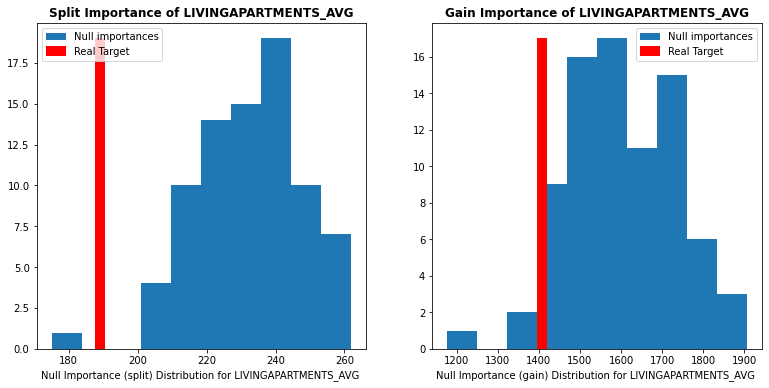

In [227]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='LIVINGAPARTMENTS_AVG')

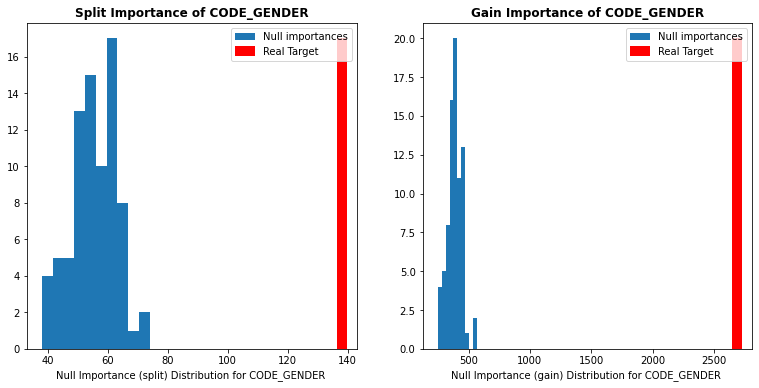

In [228]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CODE_GENDER')

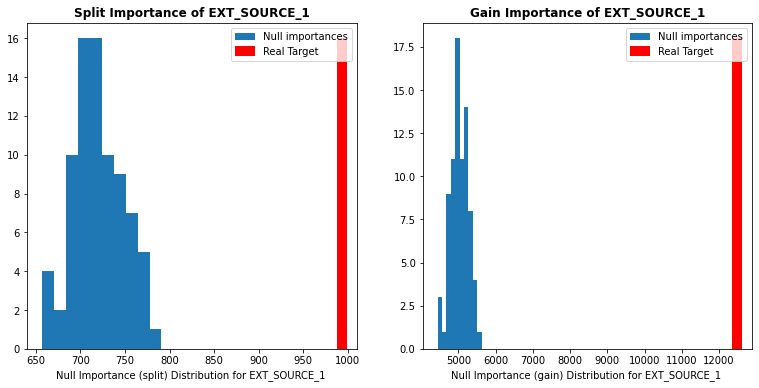

In [229]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_1')

[230.4057411  183.5421825  167.39193231 127.68947053 142.67572392
 108.46344924 198.76257346 245.30153279 131.97195999 165.39144003
 167.26287115 175.31817961 196.28019089 160.73159063 174.51995724
 170.44434988 144.26220682 159.30576604 191.98722255 190.95471072
 218.69113519 175.6171422  111.3501854  190.11132389 121.754291
 154.650485   140.23868918 142.17011274 237.75168282 172.39666251
 151.32121942 163.11844993 146.24532973 124.36085105 150.17295681
 182.28296101 189.10485125 134.82495129 195.41643883 203.40540558
 195.13034827  74.01633024 155.43092835 183.33944952 201.82035768
 184.46351456 164.24105144 233.49712898 219.15880808 160.84774631
 142.34613907 154.87824816 204.80850872 284.60930002 154.55085838
 115.13632854 204.62936044 157.85712349 172.68921501 213.34567684
 131.95987376 153.19306668 129.39013451 142.37302566 235.03468007
 229.62321079 110.72652763 173.75089592 213.84144063 199.32277155
  94.68795037 180.19823813 129.68470001 233.16587576 174.23603773
 192.3019886

[776.04071201 695.41805432 651.42126969 879.09687717 845.50565619
 831.80653075 687.20072428 733.88590953 678.81644563 686.81779689
 566.78193077 741.45441821 623.92004641 685.70757489 783.15407334
 728.28052836 652.20954524 662.62042609 689.13139872 548.19580668
 747.98087609 689.358869   574.12866757 681.91975396 734.53901624
 802.8047198  718.117439   652.43055491 626.53325731 595.87647414
 656.9595501  703.92837718 652.88906533 784.50445552 722.43165396
 783.01641624 770.4145403  673.06712523 714.49613506 821.37814934
 542.00943811 680.88675572 642.07388728 718.09567627 753.98311131
 643.49011423 600.04273173 608.41514084 900.38634441 693.80300268
 776.25418204 692.18579842 680.39114831 871.04218154 645.39435942
 658.70312665 702.60477582 597.97138975 946.96422752 666.18965212
 673.02314352 751.78169809 928.3152384  728.4655557  789.64115093
 778.18706212 725.31267649 753.53772985 612.95094569 778.36635878
 786.64797376 823.99706809 566.32508729 898.44808405 639.28593616
 804.28074

 108.2141304   64.75556087  50.57781935 205.1253407   81.48378897]
[128.46838543 153.66965938 118.05961197  80.8821271  169.94187272
 219.47732903  87.47324228 176.63627426 145.06605119 150.95527017
 271.60423677  88.33258963 139.82955559  85.31662719 116.21479642
 117.44171211 124.67463064 136.3220585  145.84499872 166.98250782
 151.68151045 149.4758324   82.46030998 194.5549944  154.68558211
 195.42291141 110.38085062 121.3223207  179.97020541 130.21926494
 166.01135039 169.98147592 153.43675196  95.15305972 214.42545104
 139.98020887 104.41846061 152.85903978 180.78892934 170.75401866
 221.78205156  85.96073335 146.87807563 141.74017537 136.86236048
  71.56737947 134.0620892  111.41866642 121.18319199 164.45463397
 154.36083609 135.71196985  97.04403958 106.67112924 124.65204552
 151.91083187 179.26558704 151.20802438 145.60648482 130.25564769
 105.81556168 146.89456445 137.32979178 163.61250899 126.61627018
 122.43501973 114.06163955 199.15966988 121.19581902 175.31089091
 123.8148

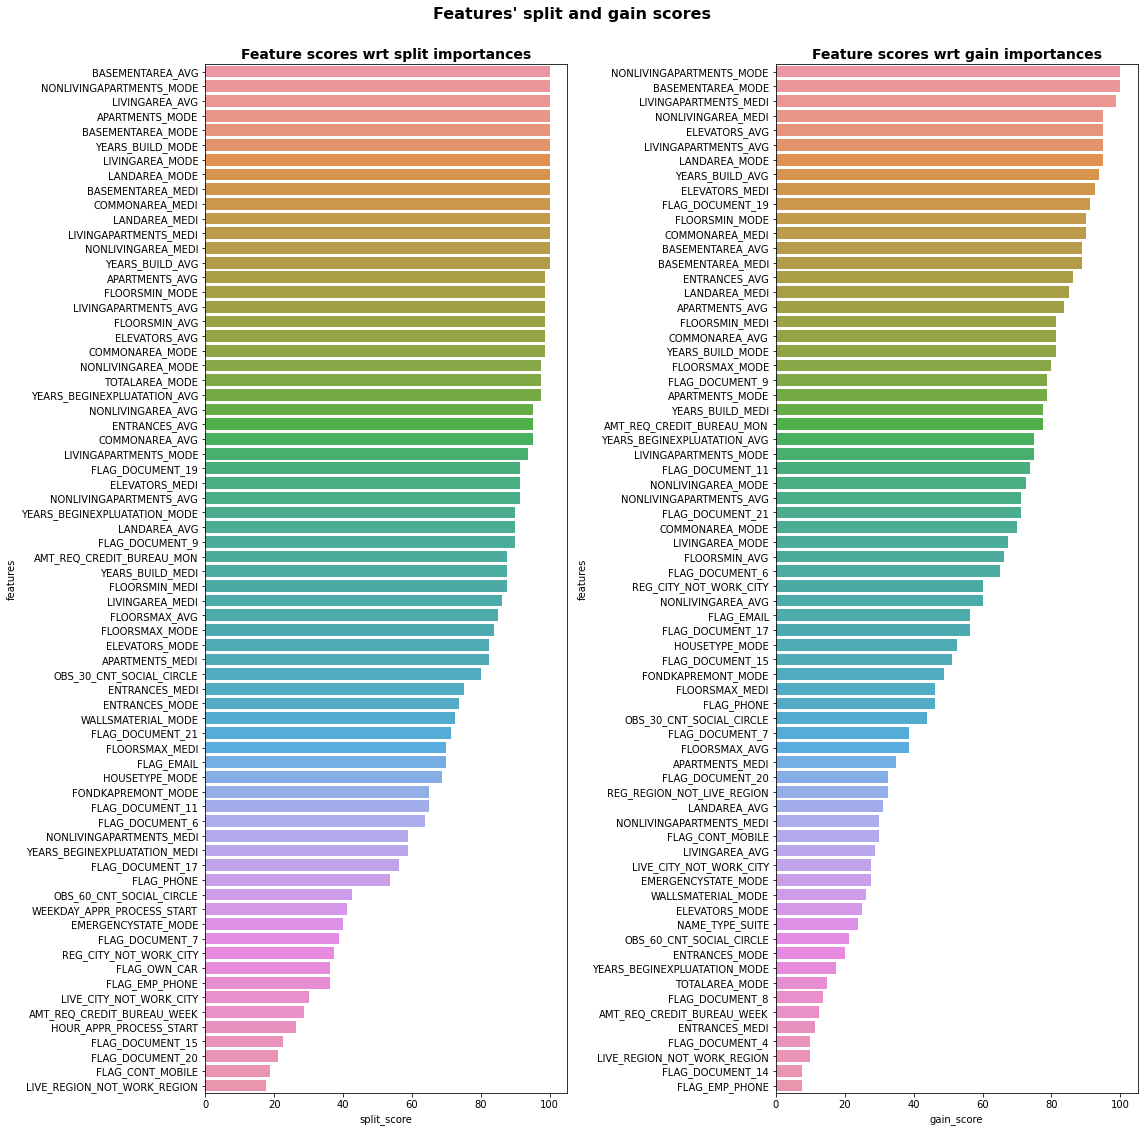

In [230]:
# 関係ない特徴量を削除した場合の影響度の確認
correlation_scores = []
for _f in actual_imp_df['features'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['features'] == _f, 'imporance_gain'].values
    print(f_null_imps)
    f_act_imps = actual_imp_df.loc[actual_imp_df['features'] == _f, 'imporance_gain'].values
#     print(f_act_imps)
    gain_score = 100 * (f_null_imps > np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
#     print((np.percentile(f_act_imps, 25)).sum())
    f_null_imps = null_imp_df.loc[null_imp_df['features'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['features'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps > np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))
    
corr_scores_df = pd.DataFrame(correlation_scores, columns=['features', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='features', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='features', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [245]:
null_importance_feats = corr_scores_df.loc[corr_scores_df['gain_score'] > 0, 'features']

In [3]:
# null_importanceでgainスコア0以上の特徴量等
null_importance_feat = ['NAME_TYPE_SUITE','FLAG_EMP_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
 'CNT_FAM_MEMBERS','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
 'APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG','COMMONAREA_AVG',
 'ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE',
 'FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI','YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE','OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_11','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_17','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21','AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON']

In [250]:
# train = pd.read_csv(DIR_PATH+'application_train.csv')

In [14]:
train_null = train[null_importance_feat]
test_null = test[null_importance_feat]
numerical_feats = train.dtypes[train.dtypes != 'object'].index
categorical_feats = train.dtypes[train.dtypes == 'object'].index

print(numerical_feats, len(numerical_feats))
print(categorical_feats, len(categorical_feats))

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106) 106
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object') 16


In [15]:
# 目的変数と説明変数を分類・ID情報の削除
train_y = train['TARGET']
train = train.drop('TARGET', axis=1)
train = train.drop('SK_ID_CURR', axis=1)
test = test.drop('SK_ID_CURR', axis=1)

In [16]:
# このコンペだと他にもlabel encodingとかtarget encodingとかあるけど、多分適さないのでone-hotでやっていく
def one_hot_encoding(df):
    df = pd.get_dummies(df)
    return df

In [19]:
# train, testデータのカテゴリーデータを数値データにone-hot-encoding
train = one_hot_encoding(train_null)
test = one_hot_encoding(test_null)

In [20]:
train

,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_17,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1,1,1,0,1.0,10,0,0,0,0,0,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,0.0149,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,1,1,1,0,2.0,11,0,0,0,0,0,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,0.0714,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,1,1,1,0,1.0,9,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,2.0,17,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1.0,11,0,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,1,0

In [21]:
test

,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_17,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1,1,0,1,2.0,18,0,0,0,0,0,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,0.0392,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,1,1,0,0,2.0,9,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,2.0,14,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,4.0,11,0,0,0,0,0,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,0.3750,0.0417,0.2042,0.2404,0.3673,0.0386,0.0800,0.3109,0.2049,0.9970,0.9608,0.1176,0.3222,0.2759,0.3750,0.0417,0.2089,0.2626,0.3827,0.0389,0.0847,0.3081,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.3750,0.0417,0.2078,0.2446,0.3739,0.0388,0.0817,0.3700,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
4,1,1,0,0,3.0,5,0,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,

In [22]:
# エンコーディング後のカラムに差が発生しているのでその対応
train_col = list(train.columns)
test_col = list(test.columns)

In [23]:
no_feats = []
for i in range(len(train_col)):
    if train_col[i] not in test_col:
        no_feats.append(train_col[i])

In [24]:
no_feats

[]

In [109]:
# 直前で求めたtestデータに存在しないカラムをtrainデータから削除
train = train.drop(no_feats, axis=1)

In [25]:
# LightGBMを使う際にtrain, testにjson型のデータが入っている為、それを解決する為の処理
train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train.columns]
test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test.columns]

In [111]:
# とりあえずsubmit　以下trainデータでモデル学習

# lgbm = lgbm.LGBMRegressor()
params = {"objective":"binary", 
                  "metric":"binary_logloss", 
                  "verbosity": -1}

X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.2)


    #データ読み込み
train_data=lgbm.Dataset(X_train,label=y_train)

    #パラメータ設定
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

    #学習
num_round=50
start=datetime.now()
lgbm=lgbm.train(param,train_data,num_round)
stop=datetime.now()

execution_time_lgbm = stop-start
execution_time_lgbm

[LightGBM] [Info] Number of positive: 19914, number of negative: 226094
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9300
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080949 -> initscore=-2.429528
[LightGBM] [Info] Start training from score -2.429528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

datetime.timedelta(seconds=13, microseconds=855628)

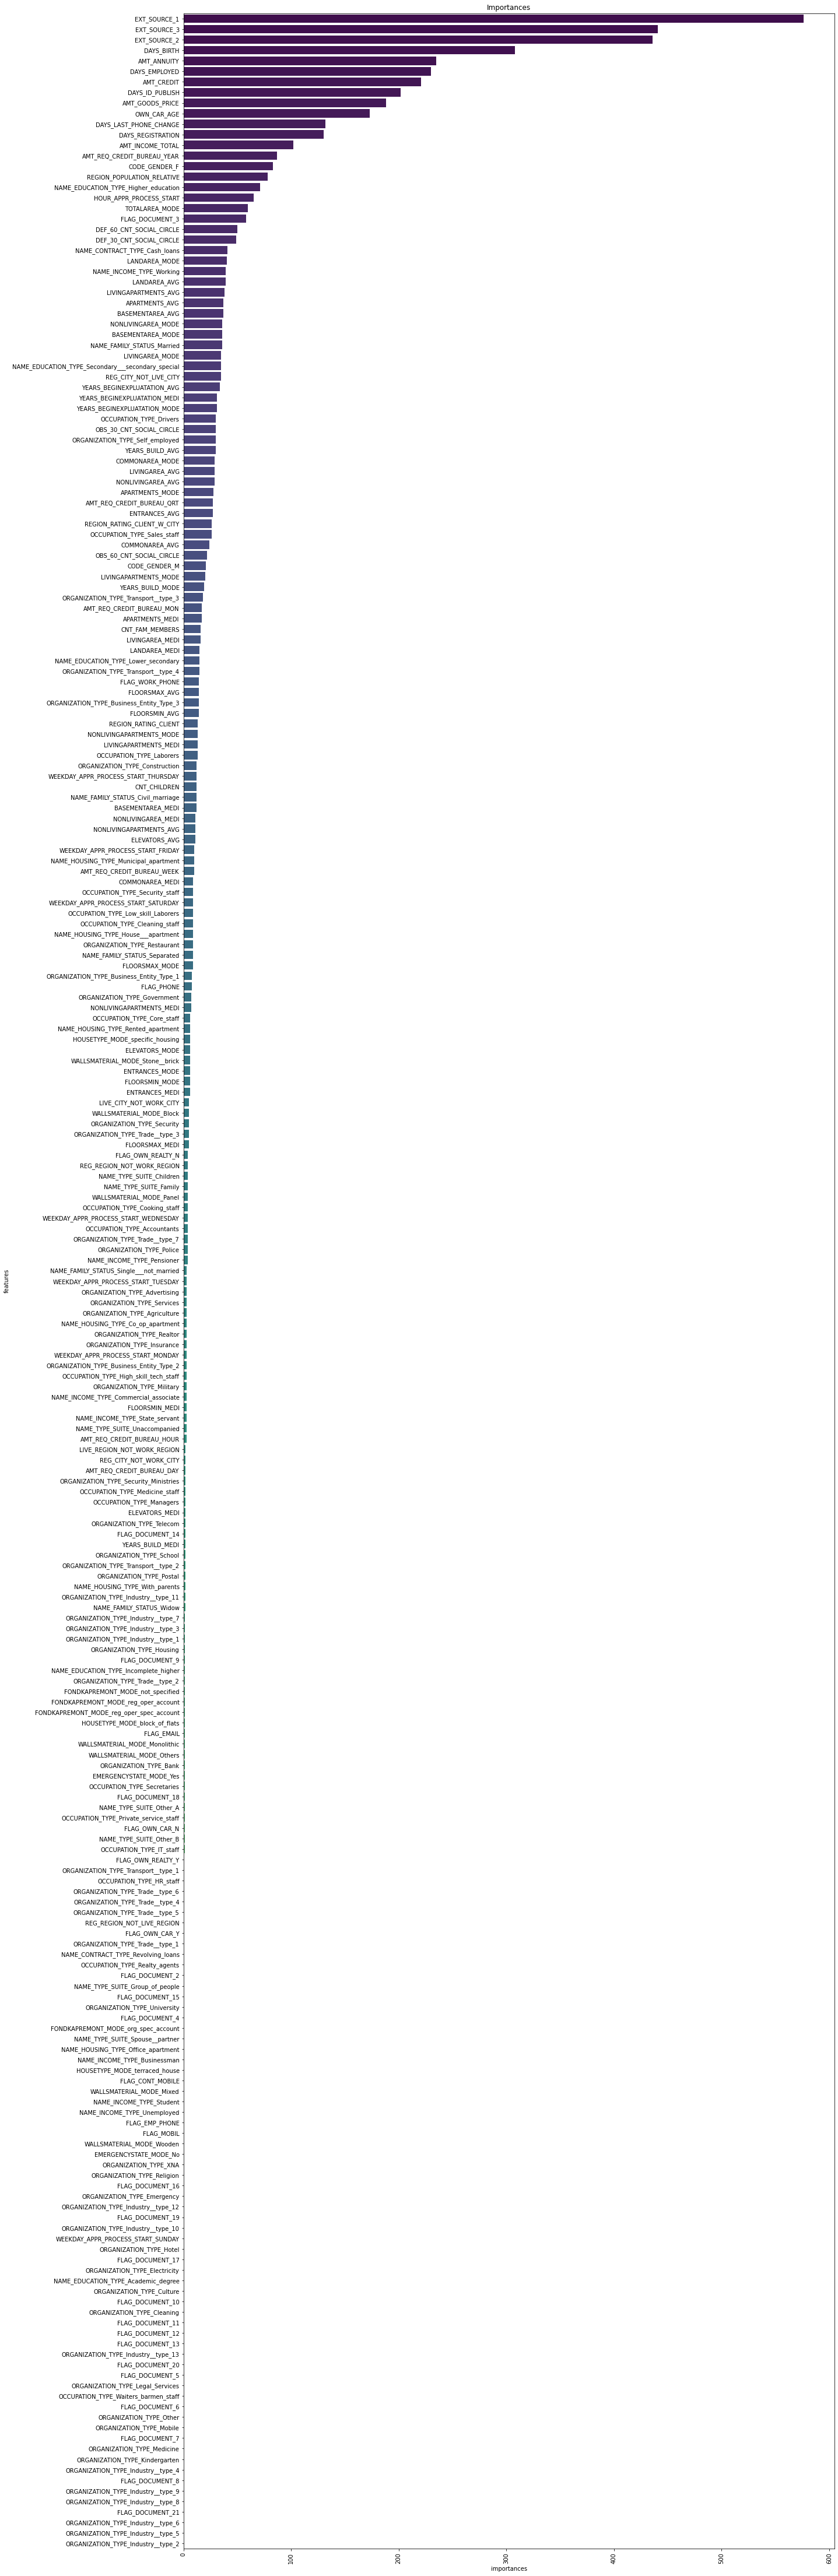

In [112]:
# 学習したモデルの各特徴量毎の重要度出力
train_feat = list(train.columns)
# train_feat.remove('SalePrice')
result = pd.DataFrame([lgbm.feature_importance(), train_feat]).T
result.columns = ['importances', 'features']
result.sort_values(by='importances', ascending=False, inplace=True)

plt.figure(figsize=(20,80))
plt.title('Importances')
# plt.rcParams['font.size']=10
sns.barplot(y=result['features'], x=result['importances'], palette='viridis')
plt.xticks(rotation=90)
plt.show() 

In [113]:
result[result['importances'] > 0]

,importances,features
27,576,EXT_SOURCE_1
29,441,EXT_SOURCE_3
28,436,EXT_SOURCE_2
6,308,DAYS_BIRTH
3,235,AMT_ANNUITY
...,...,...
115,1,NAME_TYPE_SUITE_Other_A
154,1,OCCUPATION_TYPE_Private_service_staff
108,1,FLAG_OWN_CAR_N
116,1,NAME_TYPE_SUITE_Other_B


In [ ]:
# publicスコアが良かった時の特徴量をここに更新(public: 0.74330)
good_feats = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'TOTALAREA_MODE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE_Cash_loans',
       'CODE_GENDER_F', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Higher_education',
       'NAME_EDUCATION_TYPE_Secondary___secondary_special',
       'NAME_FAMILY_STATUS_Married', 'OCCUPATION_TYPE_Drivers',
       'ORGANIZATION_TYPE_Self_employed']

In [128]:
# 低重要度を削除
threshold = 30
no_feats = result.loc[result['importances'] < threshold, 'features']
print('閾値以下の特徴量数: ', len(no_feats))
print('閾値以下の特徴量等: \n', no_feats)

閾値以下の特徴量数:  199
閾値以下の特徴量等: 
 48                        COMMONAREA_MODE
41                         LIVINGAREA_AVG
43                      NONLIVINGAREA_AVG
44                        APARTMENTS_MODE
102             AMT_REQ_CREDIT_BUREAU_QRT
                      ...                
192    ORGANIZATION_TYPE_Industry__type_8
97                       FLAG_DOCUMENT_21
190    ORGANIZATION_TYPE_Industry__type_6
189    ORGANIZATION_TYPE_Industry__type_5
186    ORGANIZATION_TYPE_Industry__type_2
Name: features, Length: 199, dtype: object


In [26]:
test_ver2 = test.drop(columns=no_feats, axis=1)
train_ver2 = train.drop(columns=no_feats, axis=1)
train_ver2

,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_17,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FONDKAPREMONT_MODE_not_specified,FONDKAPREMONT_MODE_org_spec_account,FONDKAPREMONT_MODE_reg_oper_account,FONDKAPREMONT_MODE_reg_oper_spec_account,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_specific_housing,HOUSETYPE_MODE_terraced_house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone__brick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1,1,1,0,1.0,10,0,0,0,0,0,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,0.0149,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,1,1,1,0,2.0,11,0,0,0,0,0,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,0.0714,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,1,1,1,0,1.0,9,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,2.0,17,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1.0,11,0,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0

In [28]:
# 重要度が高いカラムの欠損値
train_ver2.isnull().sum().sum()

7823272

In [29]:
# データ分割
numerical_feats = train_ver2.dtypes[train_ver2.dtypes != 'object'].index
categorical_feats = train_ver2.dtypes[train_ver2.dtypes == 'object'].index

print(numerical_feats, len(numerical_feats))
print(categorical_feats, len(categorical_feats))

Index(['FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY',
       ...
       'HOUSETYPE_MODE_terraced_house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone__brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=103) 103
Index([], dtype='object') 0


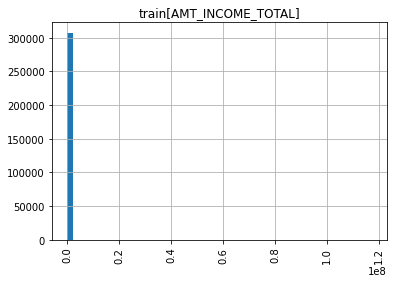

##################################################


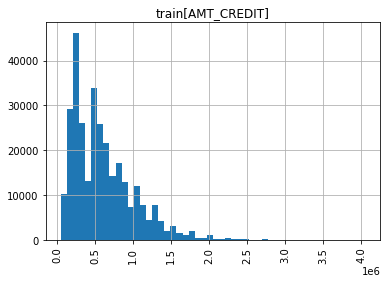

##################################################


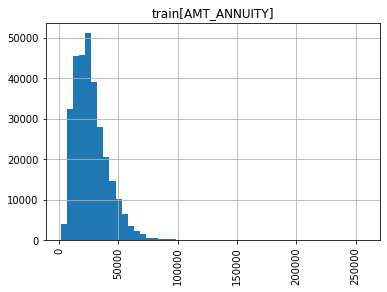

##################################################


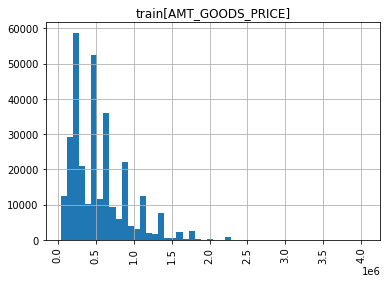

##################################################


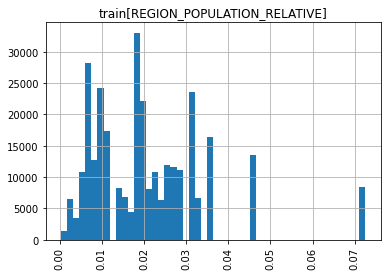

##################################################


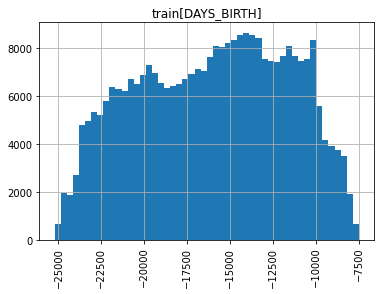

##################################################


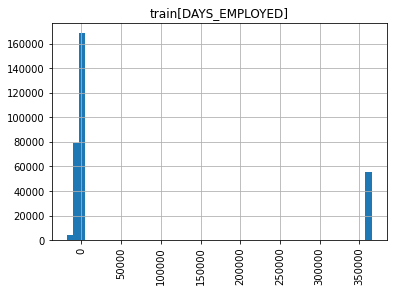

##################################################


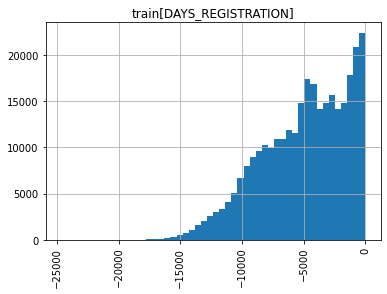

##################################################


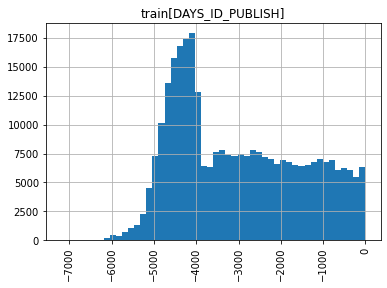

##################################################


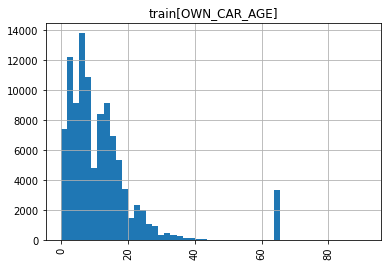

##################################################


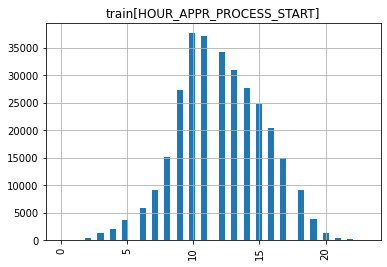

##################################################


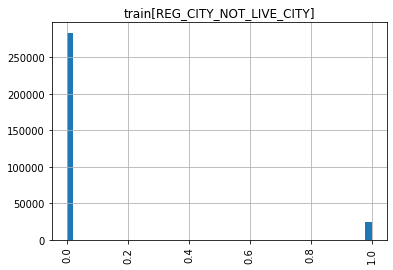

##################################################


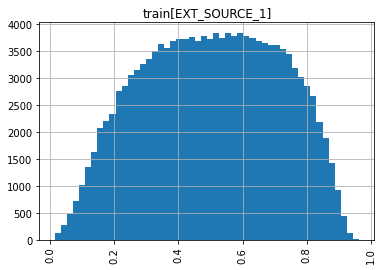

##################################################


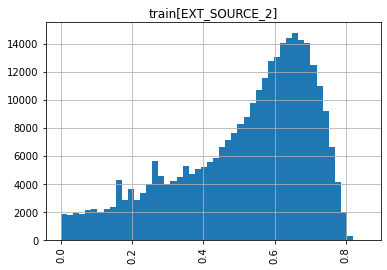

##################################################


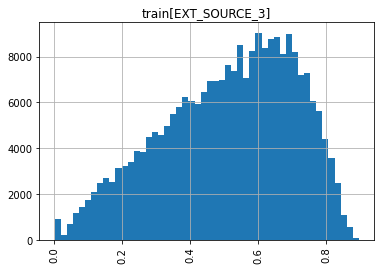

##################################################


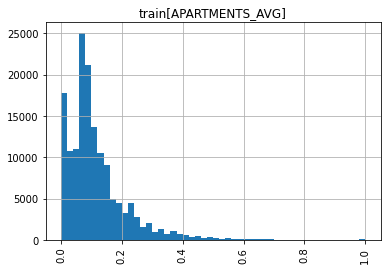

##################################################


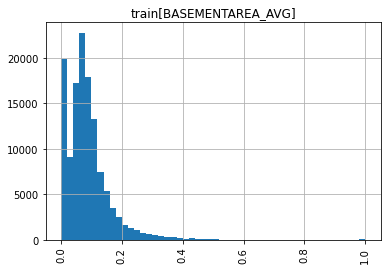

##################################################


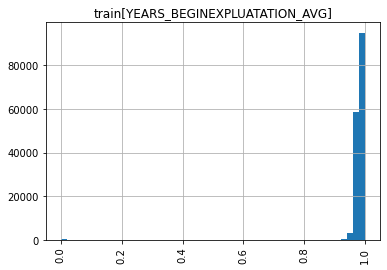

##################################################


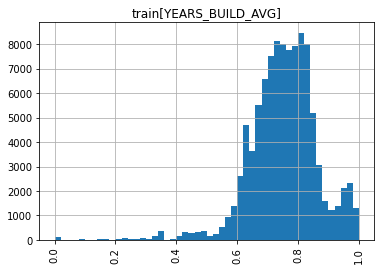

##################################################


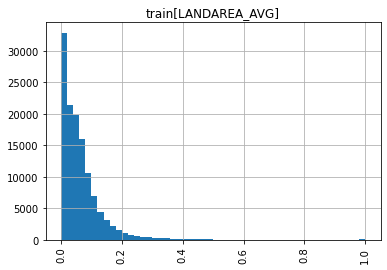

##################################################


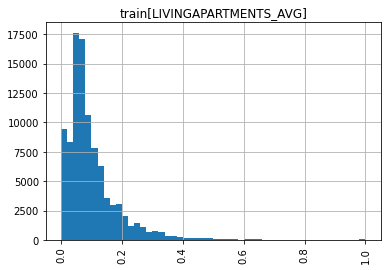

##################################################


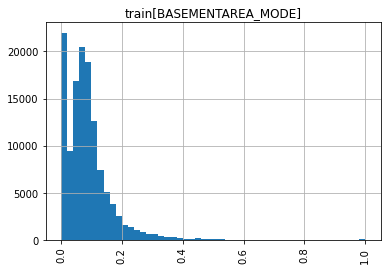

##################################################


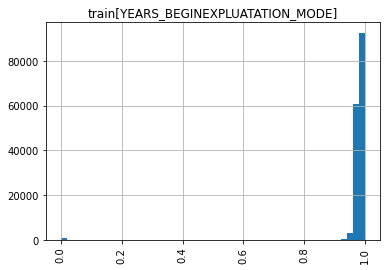

##################################################


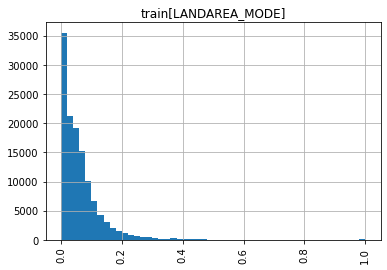

##################################################


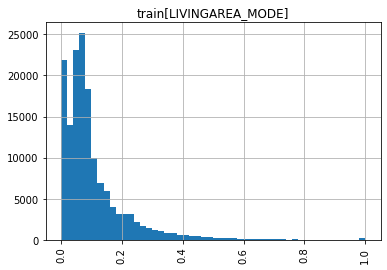

##################################################


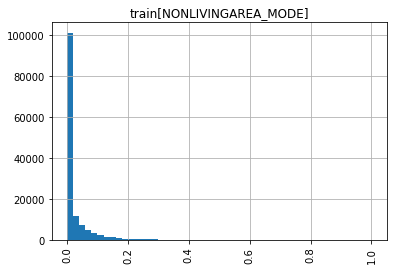

##################################################


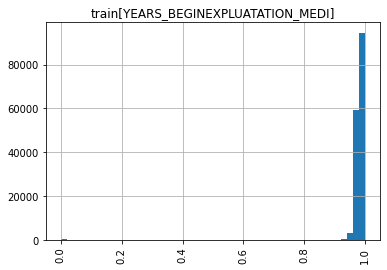

##################################################


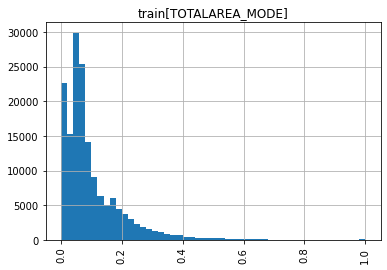

##################################################


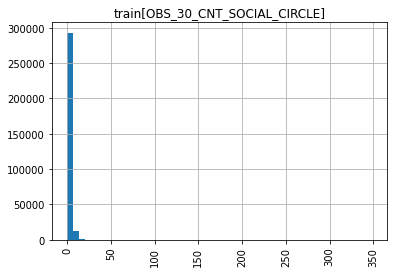

##################################################


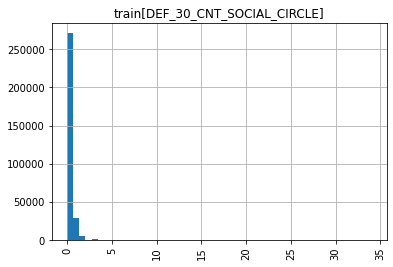

##################################################


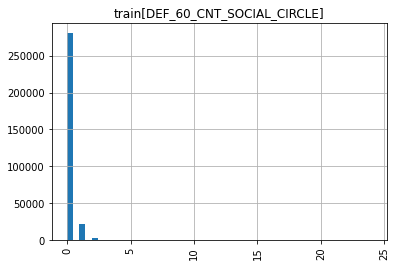

##################################################


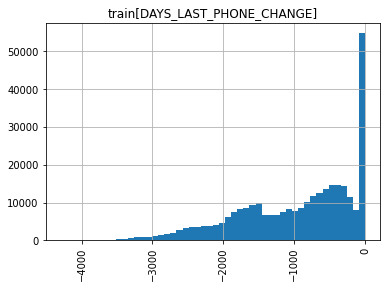

##################################################


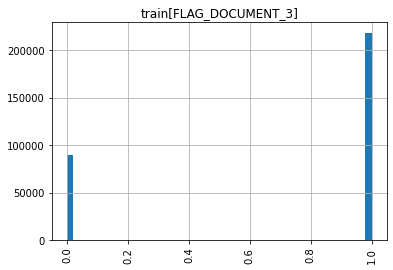

##################################################


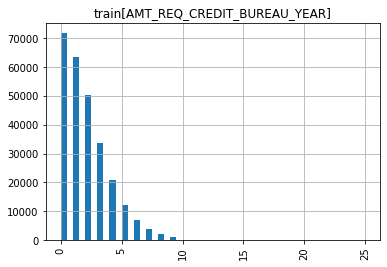

##################################################


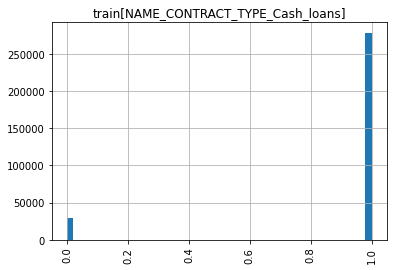

##################################################


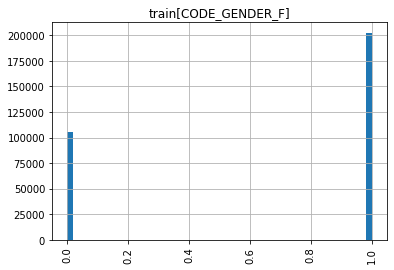

##################################################


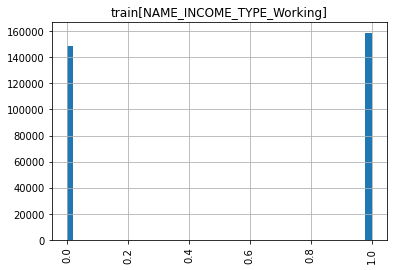

##################################################


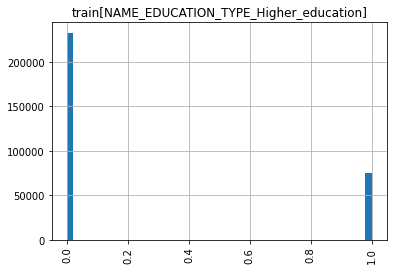

##################################################


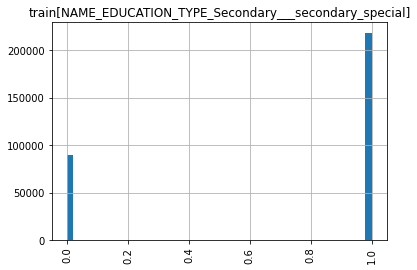

##################################################


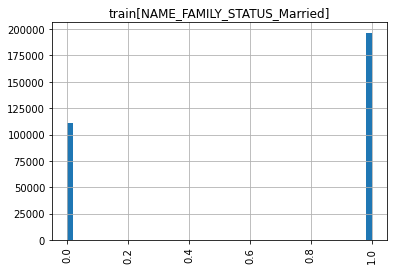

##################################################


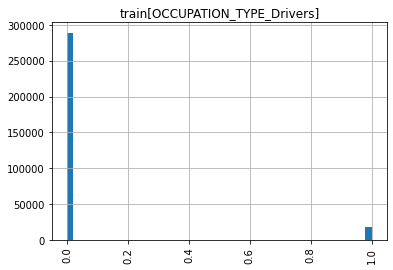

##################################################


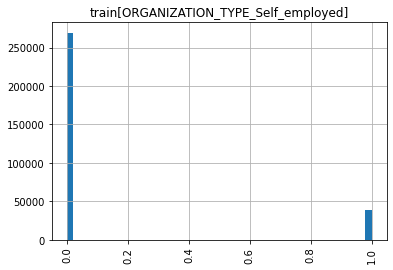

##################################################


In [132]:
# 数値データの分布
for col in numerical_feats:
    plt.title('train[{}]'.format(col))
    train[col].hist(bins=50)
    plt.xticks(rotation=90)
    plt.show()
    
    print('#'*50)

In [30]:
train_ver2

,FLAG_EMP_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_17,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse__partner,NAME_TYPE_SUITE_Unaccompanied,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,FONDKAPREMONT_MODE_not_specified,FONDKAPREMONT_MODE_org_spec_account,FONDKAPREMONT_MODE_reg_oper_account,FONDKAPREMONT_MODE_reg_oper_spec_account,HOUSETYPE_MODE_block_of_flats,HOUSETYPE_MODE_specific_housing,HOUSETYPE_MODE_terraced_house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone__brick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1,1,1,0,1.0,10,0,0,0,0,0,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,0.0149,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,1,1,1,0,2.0,11,0,0,0,0,0,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,0.0714,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,1,1,1,0,1.0,9,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,2.0,17,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1.0,11,0,0,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0

In [73]:
# これに入力するデータはtrain_ver2, test_ver2
def feature_engineer(df):
    # 欠損値処理、新規特徴量作成、DAYS系カラムの値補正
#     df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'] / 365)
#     df['DAYS_LAST_PHONE_CHANGE'] = abs(df['DAYS_LAST_PHONE_CHANGE'] / 365)
#     df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED'] / 365)
#     df['DAYS_REGISTRATION'] = abs(df['DAYS_REGISTRATION'] / 365)
#     df['DAYS_ID_PUBLISH'] = abs(df['DAYS_ID_PUBLISH'] / 365)
#     df.fillna({'OWN_CAR_AGE': 0, 'EXT_SOURCE_1':df['EXT_SOURCE_1'].mean(), \
#                       'EXT_SOURCE_2':df['EXT_SOURCE_2'].mean(), \
#                       'EXT_SOURCE_3':df['EXT_SOURCE_3'].mean()}, inplace=True)
    df.fillna({'OWN_CAR_AGE': 0}, inplace=True)
#     df.fillna({'AMT_ANNUITY':df['AMT_ANNUITY'].mean(), \
#              'AMT_GOODS_PRICE':df['AMT_GOODS_PRICE'].mean()}, inplace=True)
    df.fillna({'AMT_REQ_CREDIT_BUREAU_YEAR':0}, inplace=True)
    df.fillna({'TOTALAREA_MODE':df['TOTALAREA_MODE'].mean()}, inplace=True)
    df.fillna({'DEF_30_CNT_SOCIAL_CIRCLE':0}, inplace=True)
    
    # 収入に対する借入比率
#     df['credit_ratio'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    # DAYS_EMPLOEE補正
#     for i in range(len(df)):
#         if df.loc[i, 'DAYS_EMPLOYED'] > 50:
#             df.loc[i, 'DAYS_EMPLOYED'] = df.loc[i, 'DAYS_EMPLOYED'] / 100
            
    # よくわからんけどとりあえず対数とってみる
#     log_feats = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION', 'credit_ratio',
#                 'APARTMENTS_AVG', 'BASEMENTAREA_AVG']
    log_feats = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG']
    df[log_feats] = df[log_feats].apply(np.log)
    df[df[log_feats] == float('-inf')] = 0
    
    # その他のAMTデータでも比率をとってみる
#     df['AMT_ANNUITY_ratio'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
#     df['AMT_GOODS_PRICE_ratio'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    
    return df

In [74]:
# 提出用csv作成
# こうするなら本当はDataFrameから作るべきだな
def create_submission(model, test_df, test_id):
    test_pred = model.predict(test_df)
    submission = pd.read_csv(DIR_PATH + 'sample_submission.csv')
    submission['SK_ID_CURR'] = test_id
    submission['TARGET'] = test_pred
    submission.to_csv('submission.csv', index=False)
    print('submission done!')

In [75]:
train_ver3 = feature_engineer(train_ver2)

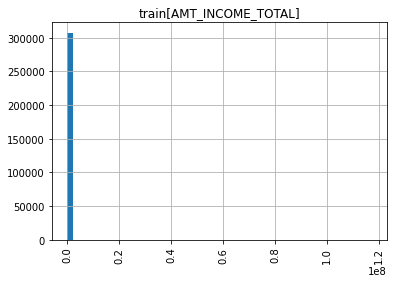

##################################################


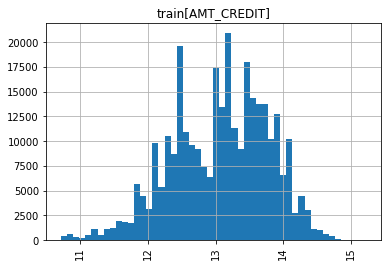

##################################################


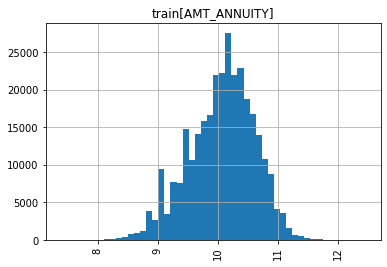

##################################################


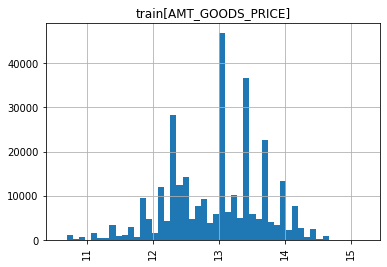

##################################################


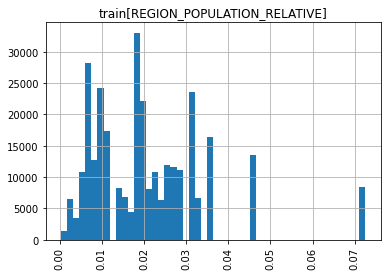

##################################################


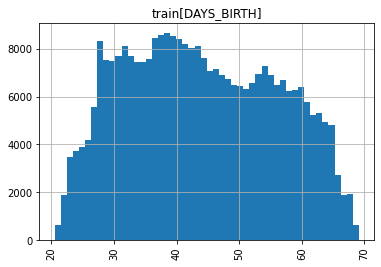

##################################################


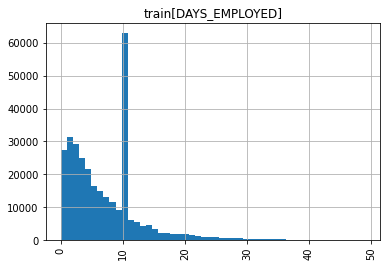

##################################################


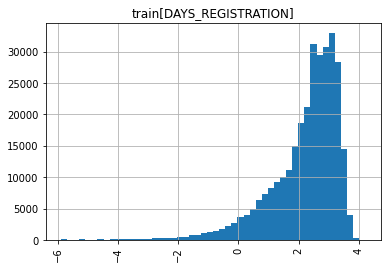

##################################################


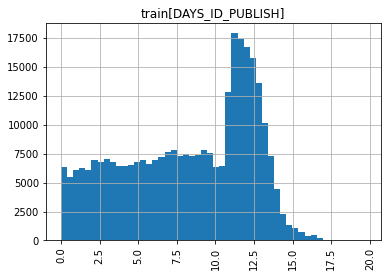

##################################################


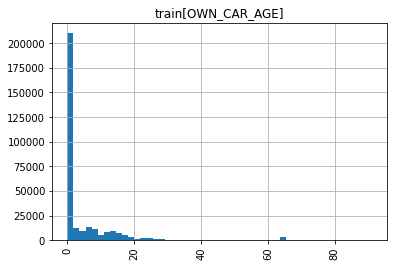

##################################################


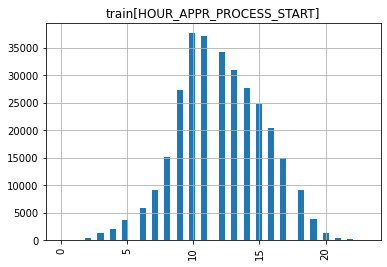

##################################################


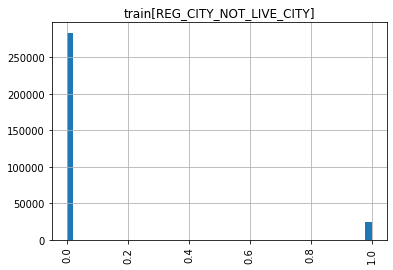

##################################################


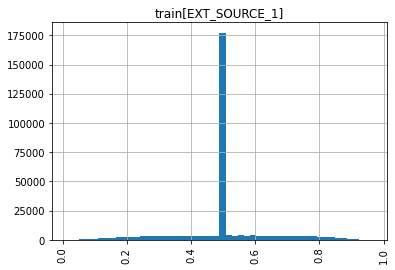

##################################################


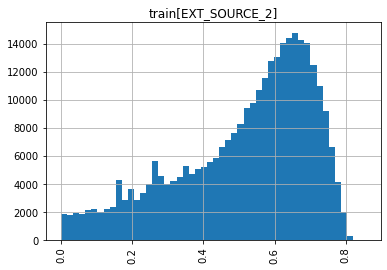

##################################################


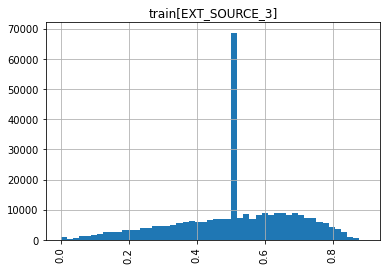

##################################################


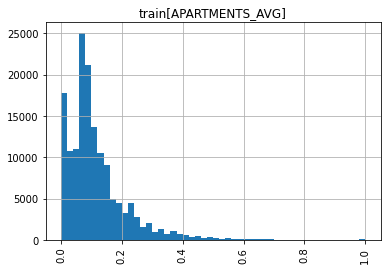

##################################################


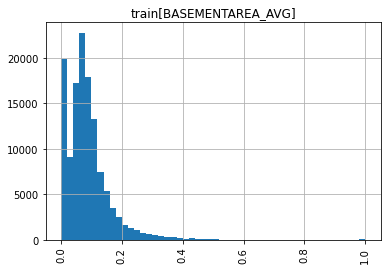

##################################################


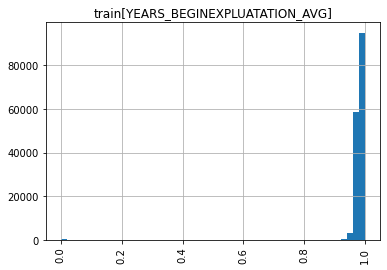

##################################################


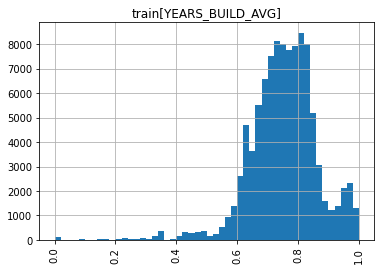

##################################################


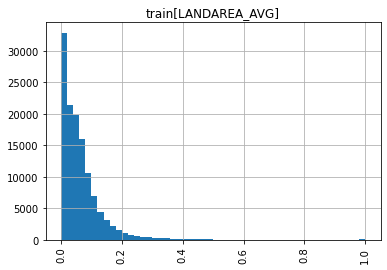

##################################################


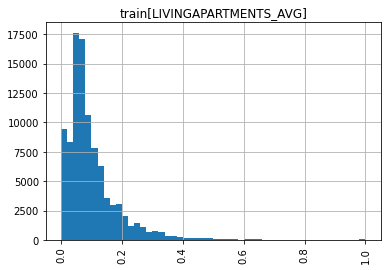

##################################################


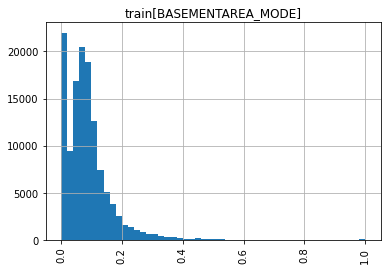

##################################################


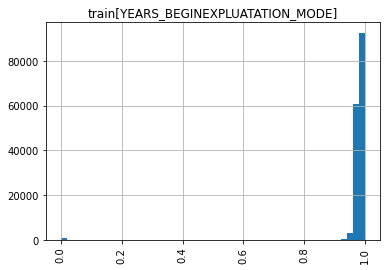

##################################################


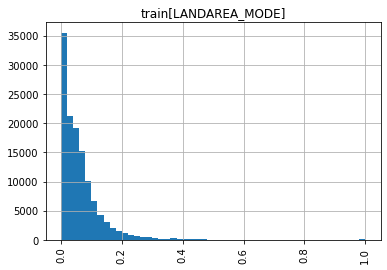

##################################################


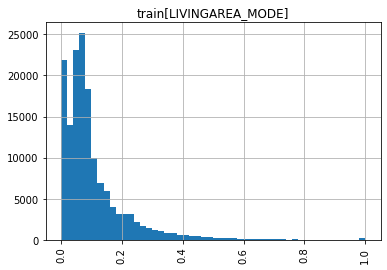

##################################################


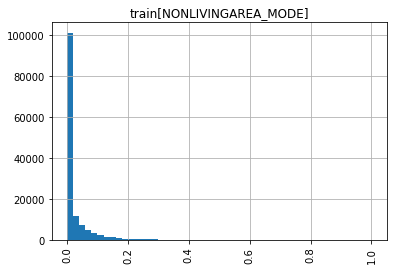

##################################################


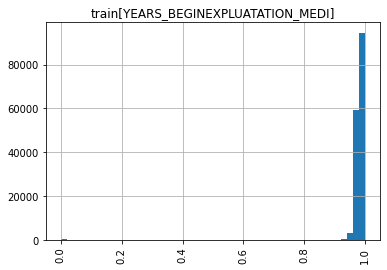

##################################################


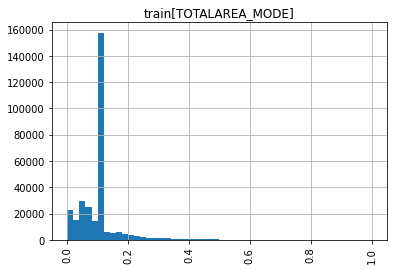

##################################################


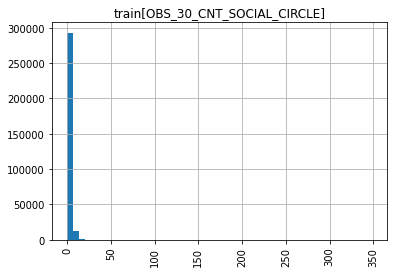

##################################################


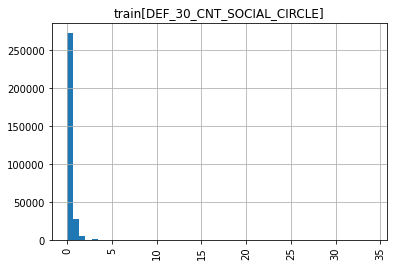

##################################################


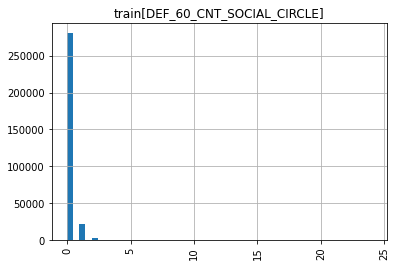

##################################################


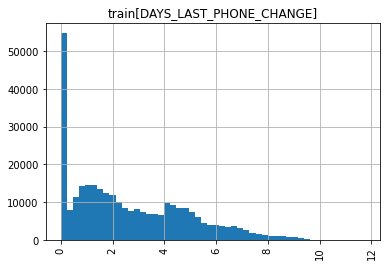

##################################################


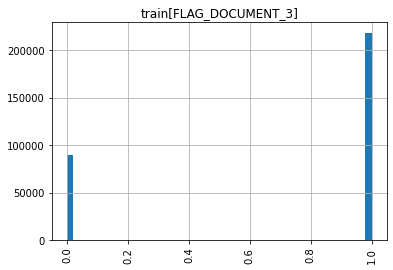

##################################################


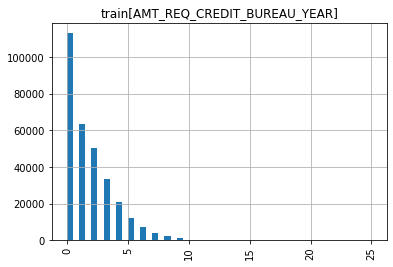

##################################################


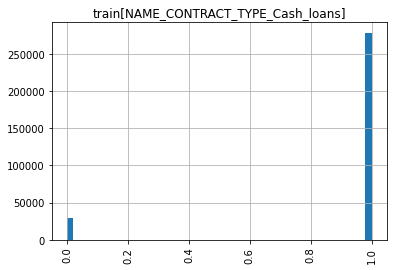

##################################################


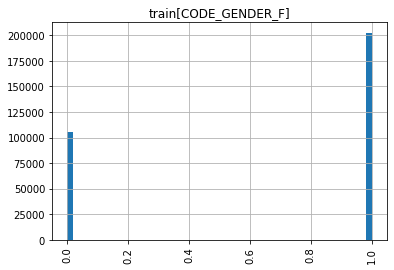

##################################################


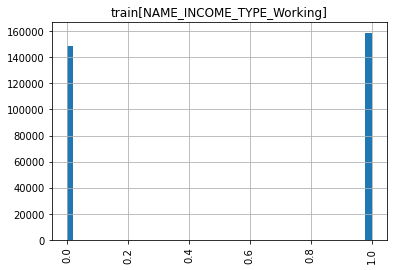

##################################################


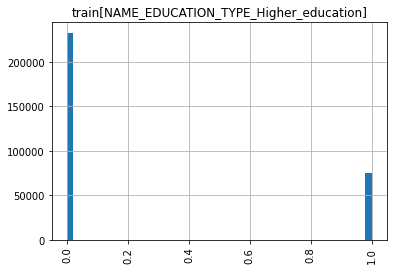

##################################################


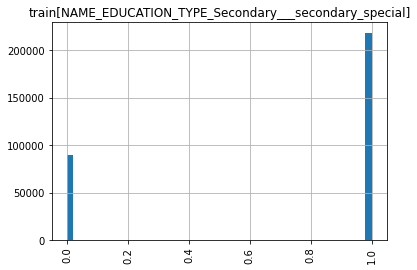

##################################################


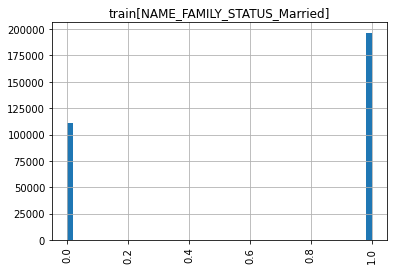

##################################################


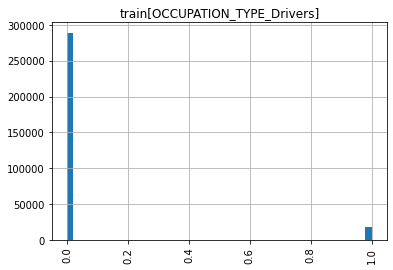

##################################################


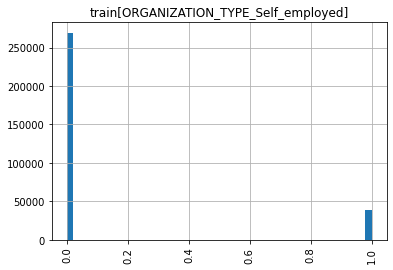

##################################################


In [137]:
# 数値データの分布
for col in numerical_feats:
    plt.title('train[{}]'.format(col))
    train_ver3[col].hist(bins=50)
    plt.xticks(rotation=90)
    plt.show()
    
    print('#'*50)

In [81]:
import lightgbm as lgbm
# k-fold cross validation実装（lightgbm ver）

# 前処理済みデータを分割
X_train, X_test, y_train, y_test = train_test_split(train_ver3, train_y, test_size=0.2)
# 5-fold CVモデルの学習
# 5つのモデルを保存するリストの初期化
models = []
# aucスコアを格納するリスト
auc_score_list = [0]

best_eval_result = {}
# 学習データの数だけの数列
row_no_list = list(range(len(y_train)))

# インスタンス化
K_fold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# クロスバリデーションを10回行って最も良かった結果を提出させる
    # KFoldクラスで分割したn_split数だけ実行
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = y_train.iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = y_train.iloc[eval_cv_no]

    # 学習用
    lgbm_train = lgbm.Dataset(X_train_cv, y_train_cv, free_raw_data=False)
    # 検証用
    lgbm_eval = lgbm.Dataset(X_eval_cv, y_eval_cv, reference=lgbm_train, free_raw_data=False)
    # パラメータ設定
    params = {'task': 'train',
            'lambda_l1': 0.000466755402379016,
            'lambda_l2': 0.00205831675835705,
            'num_leaves':150,
            'objective':'binary',
            'metric': 'binary_logloss',
            'max_depth':7,
            'learning_rate':.05,
            'max_bin':200}
    evaluation_results = {}
    model = lgbm.train(params, lgbm_train, num_boost_round=1000, valid_names=['train', 'valid'],
                       valid_sets=[lgbm_train, lgbm_eval], evals_result=evaluation_results,
                    early_stopping_rounds=20, verbose_eval=-1)

    # テストデータで予測
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    #     y_pred_max = np.argmax(y_pred, axis=1)

    auc_score = roc_auc_score(y_test,y_pred)
    print('auc_score: ', auc_score)
    if auc_score_list[-1] < auc_score:
        best_eval_result = evaluation_results

    auc_score_list.append(auc_score)
    models.append(model)


best_auc_number = np.argmax(auc_score_list)
best_model = models[best_auc_number - 1]

[LightGBM] [Info] Number of positive: 15885, number of negative: 180921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6107
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080714 -> initscore=-2.432685
[LightGBM] [Info] Start training from score -2.432685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [82]:
best_eval_result

{'train': OrderedDict([('binary_logloss',
               [0.27990841130958166,
                0.27938726524009033,
                0.2789053260936763,
                0.2784705559348313,
                0.27806613745764897,
                0.27769905728650796,
                0.27733274486098825,
                0.276989212140242,
                0.27666834894310155,
                0.2763602675507705,
                0.2760590910475475,
                0.27577315534956914,
                0.2755206569679167,
                0.2752553827344459,
                0.2750303400444915,
                0.2747801471097905,
                0.27455355748281335,
                0.27433025241404785,
                0.2741264214260158,
                0.27392391458108256,
                0.27374920607285436,
                0.27355860199869325,
                0.2733738888321676,
                0.2732009054757052,
                0.27304544157538924,
                0.2728787985886568,
          

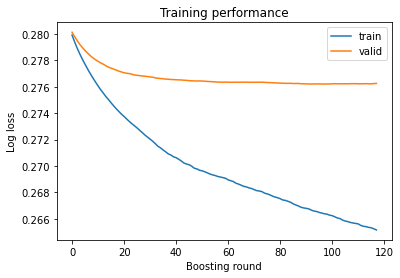

In [83]:
# 学習過程の可視化
plt.plot(best_eval_result['train']['binary_logloss'], label='train')
plt.plot(best_eval_result['valid']['binary_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.savefig('cv_logloss.jpg')
plt.show()

完全に過学習

In [84]:
# クロスバリデーション後用提出
# import lightgbm as lgbm

X_train, X_test, y_train, y_test = train_test_split(train_ver3, train_y, test_size=0.2)
test_ver3 = feature_engineer(test_ver2)

# train_data=lgbm.Dataset(X_train,label=y_train)

#学習
num_round=50
# lgbm=lgbm.train(most_best_params,train_data,num_round)
y_pred = best_model.predict(X_test, num_iteration=best_model.best_iteration)
#     y_pred_max = np.argmax(y_pred, axis=1)
    
auc_score = roc_auc_score(y_test,y_pred)
print(auc_score)
create_submission(best_model, test_ver3, test_id)

0.6532074398814024
submission done!


クロスバリデーションのみ：0.67591→0.74129<br>
やった事：<br>
・重要度の閾値を50→40に<br>
・パラメータをoptuna参考にいじってみた<br>

クロスバリデーションのみ：0.74129→0.73399<br>
やった事：<br>
・重要度の閾値を40→30に<br>
どうやら閾値はなんとなく40がいいのかもしれない<br>

クロスバリデーションのみ：0.74129→0.73962<br>
やった事：<br>
・重要度の閾値を40で固定<br>
・欠損値埋めを辞めてみる<br>
なんか誤差の範囲でaucが上振れ下振れしている。→クロスバリデーションが安定しないから？<br>
epoch追加して10回とかでやってみる<br>

クロスバリデーションのみ：0.73962→0.69240<br>
やった事：<br>
・重要度の閾値を40で固定<br>
・欠損値埋めを辞めてみる<br>
・クロスバリデーションを指定したepoch数分実施(10回)<br>
欠損値埋めを辞めた結果ひどいことになった。埋めた方が良さそう。<br>

クロスバリデーションのみ：0.69240→0.70749<br>
やった事：<br>
・重要度の閾値を40で固定<br>
・欠損値埋めを再開<br>
・クロスバリデーションを指定したepoch数分実施(10回)<br>
スコアゴリゴリ下がったのでepochはやめます<br>

クロスバリデーションのみ：0.70749→0.74330<br>
やった事：<br>
・重要度の閾値を、40特徴量程度拾えるようにチューニング<br>
・欠損値埋めを再開<br>
スコアは戻ったが、最初のimportance次第でどうにでもなる。安定しない。EDA見直す<br>
→1位ソリューションのnull importanceで、特徴選定の見直しを図る<br>
target encodingもありだな？<br>

【問題2】グリッドサーチ

参考サイト:<br>
グリッドサーチに指定できる評価指標<br>
https://qiita.com/shnchr/items/f5066021b7143566f950<br>
GBDT系のパラメータチューニング<br>
https://qiita.com/KROYO/items/6607bc77bb465f5e9a3a<br>
Intro to Model Tuning: Grid and Random Search<br>
https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search<br>
LightGBMをOptunaでパラメータチューニングする<br>
https://www.inoue-kobo.com/ai_ml/lightbgm-with-optuna/index.html<br>
【機械学習】ハイパーパラメータチューニングの仕方<br>
https://qiita.com/R1ck29/items/50ba7fa5afa49e334a8f<br>

In [ ]:
# 利用可能な評価指標一覧の表示
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [81]:
# lightgbmのパラメータ一覧が見れる
# Create a default model
import lightgbm as lgb
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [57]:
# # # lightgbmでグリッドサーチ実行
# # # これだとめちゃめちゃ遅いのでちょっとやり方を変える
# import lightgbm as lgbm

# model = lgbm.LGBMClassifier()
# # 前処理済みデータを分割
# X_train, X_test, y_train, y_test = train_test_split(train_ver3, train_y, test_size=0.2)
# # グリッドサーチで使用するk-fold準備
# K_fold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # パラメーターを設定する
# param_grid = {"max_depth": [10, 25, 50, 75],
#               "learning_rate" : [0.001,0.01,0.05,0.1],
#               "num_leaves": [100,300,900,1200],
#               "n_estimators": [100,200,500]
#              }

# ## このGridSearchCV には注意が必要 scoring は そのスコアを基準にして最適化する
# grid_result = GridSearchCV(estimator = model,
#                            param_grid = param_grid,
#                            scoring = 'roc_auc',
#                            cv = K_fold,
#                            verbose=3,
#                            return_train_score = True,
#                            n_jobs = -1)

# grid_result.fit(X_train, y_train)

In [59]:
# pprint.pprint(grid_result.best_estimator_)

In [ ]:
# pprint.pprint(grid_result.best_params_)

In [ ]:
# pprint.pprint(grid_result.best_score_)

In [82]:
# これでoptunaでやれない？
# やれた。lightgbmはoptunaでやります。
import optuna.integration.lightgbm as optuna_lgb
import lightgbm as lgbm
# k-fold cross validation実装（lightgbm ver）

# 前処理済みデータを分割
X_train, X_test, y_train, y_test = train_test_split(train_ver3, train_y, test_size=0.2)
# 5-fold CVモデルの学習
# 5つのモデルを保存するリストの初期化
models = []
# aucスコアを格納するリスト
auc_score_list = [0]

best_eval_result = {}
best_params, history = {}, []
most_best_params = {}
k = 5
count = 1
# 学習データの数だけの数列
row_no_list = list(range(len(y_train)))

# インスタンス化
K_fold  = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# KFoldクラスで分割したn_split数だけ実行
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = y_train.iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = y_train.iloc[eval_cv_no]
    
    # 学習用
    lgbm_train = lgbm.Dataset(X_train_cv, y_train_cv, free_raw_data=False)
    # 検証用
    lgbm_eval = lgbm.Dataset(X_eval_cv, y_eval_cv, reference=lgbm_train, free_raw_data=False)
    # パラメータ設定
#     param = {'task': 'train',
#              'num_leaves':150,
#              'objective':'binary',
#              'max_depth':7,
#              'learning_rate':.05,
#              'max_bin':200}
#     param['metric'] = ['auc', 'binary_logloss']
    
    # optuna用パラメータ設定
    param = {'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.05,
            'feature_fraction': 0.01,
            'max_depth': 5,
            'min_child_samples': 50,
            'max_bin': 200,
            'num_leaves': 50}
#     param['metric'] = ['binary_logloss']
    evaluation_results = {}
    model = optuna_lgb.train(params, lgbm_train, num_boost_round=1500, valid_names=['train', 'valid'],
                      valid_sets=[lgbm_train, lgbm_eval], evals_result=evaluation_results,
                      early_stopping_rounds=20, verbose_eval=-1, best_params=best_params, tuning_history=history)
    
    # テストデータで予測
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
#     y_pred_max = np.argmax(y_pred, axis=1)
    
    auc_score = roc_auc_score(y_test,y_pred)
    print('auc_score: ', auc_score)
    if auc_score_list[-1] < auc_score:
        best_eval_result = evaluation_results
        most_best_params = best_params

    auc_score_list.append(auc_score)
    models.append(model)
    print('{0} / {1} times done'.format(count, k))
    count += 1


best_score_number = np.argmax(auc_score_list)
best_model = models[best_score_number]
print(most_best_params)

/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/optuna/_experimental.py:56: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  warnings.warn(
/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/optuna/_experimental.py:78: ExperimentalWarning: LightGBMTuner is experimental (supported from v1.5.0). The interface can change in the future.
  warnings.warn(




  0%|          | 0/7 [00:00<?, ?it/s]



feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	train's binary_logloss: 0.231937	valid's binary_logloss: 0.24793






feature_fraction, val_score: 0.247930:   0%|          | 0/7 [00:06<?, ?it/s]



feature_fraction, val_score: 0.247930:  14%|#4        | 1/7 [00:06<00:41,  6.96s/it][I 2021-02-02 19:20:03,734] Finished trial#0 with value: 0.24793011207606958 with parameters: {'feature_fraction': 0.8999999999999999}. Best is trial#0 with value: 0.24793011207606958.




feature_fraction, val_score: 0.247930:  14%|#4        | 1/7 [00:07<00:41,  6.96s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[115]	train's binary_logloss: 0.233407	valid's binary_logloss: 0.24778






feature_fraction, val_score: 0.247780:  14%|#4        | 1/7 [00:13<00:41,  6.96s/it]



feature_fraction, val_score: 0.247780:  29%|##8       | 2/7 [00:13<00:34,  6.83s/it][I 2021-02-02 19:20:09,758] Finished trial#1 with value: 0.2477802247670022 with parameters: {'feature_fraction': 0.6}. Best is trial#1 with value: 0.2477802247670022.




feature_fraction, val_score: 0.247780:  29%|##8       | 2/7 [00:13<00:34,  6.83s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[115]	train's binary_logloss: 0.233316	valid's binary_logloss: 0.248114






feature_fraction, val_score: 0.247780:  29%|##8       | 2/7 [00:19<00:34,  6.83s/it]



feature_fraction, val_score: 0.247780:  43%|####2     | 3/7 [00:19<00:26,  6.73s/it][I 2021-02-02 19:20:16,250] Finished trial#2 with value: 0.24811386633789462 with parameters: {'feature_fraction': 0.7}. Best is trial#1 with value: 0.2477802247670022.




feature_fraction, val_score: 0.247780:  43%|####2     | 3/7 [00:20<00:26,  6.73s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[140]	train's binary_logloss: 0.230783	valid's binary_logloss: 0.247886






feature_fraction, val_score: 0.247780:  43%|####2     | 3/7 [00:26<00:26,  6.73s/it]



feature_fraction, val_score: 0.247780:  57%|#####7    | 4/7 [00:26<00:19,  6.54s/it][I 2021-02-02 19:20:22,363] Finished trial#3 with value: 0.2478861451041045 with parameters: {'feature_fraction': 0.5}. Best is trial#1 with value: 0.2477802247670022.




feature_fraction, val_score: 0.247780:  57%|#####7    | 4/7 [00:26<00:19,  6.54s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[147]	train's binary_logloss: 0.231176	valid's binary_logloss: 0.247592






feature_fraction, val_score: 0.247592:  57%|#####7    | 4/7 [00:32<00:19,  6.54s/it]



feature_fraction, val_score: 0.247592:  71%|#######1  | 5/7 [00:32<00:12,  6.50s/it][I 2021-02-02 19:20:28,716] Finished trial#4 with value: 0.2475922747696834 with parameters: {'feature_fraction': 0.4}. Best is trial#4 with value: 0.2475922747696834.




feature_fraction, val_score: 0.247592:  71%|#######1  | 5/7 [00:32<00:12,  6.50s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[84]	train's binary_logloss: 0.237035	valid's binary_logloss: 0.248182






feature_fraction, val_score: 0.247592:  71%|#######1  | 5/7 [00:39<00:12,  6.50s/it]



feature_fraction, val_score: 0.247592:  86%|########5 | 6/7 [00:39<00:06,  6.52s/it][I 2021-02-02 19:20:35,297] Finished trial#5 with value: 0.2481822670552159 with parameters: {'feature_fraction': 0.8}. Best is trial#4 with value: 0.2475922747696834.




feature_fraction, val_score: 0.247592:  86%|########5 | 6/7 [00:39<00:06,  6.52s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	train's binary_logloss: 0.235741	valid's binary_logloss: 0.248






feature_fraction, val_score: 0.247592:  86%|########5 | 6/7 [00:45<00:06,  6.52s/it]



feature_fraction, val_score: 0.247592: 100%|##########| 7/7 [00:46<00:00,  6.59s/it]




  0%|          | 0/20 [00:00<?, ?it/s]



num_leaves, val_score: 0.247592:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[131]	train's binary_logloss: 0.233793	valid's binary_logloss: 0.247457






num_leaves, val_score: 0.247457:   0%|          | 0/20 [00:07<?, ?it/s]



num_leaves, val_score: 0.247457:   5%|5         | 1/20 [00:07<02:15,  7.13s/it][I 2021-02-02 19:20:49,578] Finished trial#7 with value: 0.24745693635461655 with parameters: {'num_leaves': 29}. Best is trial#7 with value: 0.24745693635461655.




num_leaves, val_score: 0.247457:   5%|5         | 1/20 [00:07<02:15,  7.13s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[131]	train's binary_logloss: 0.226295	valid's binary_logloss: 0.247812






num_leaves, val_score: 0.247457:   5%|5         | 1/20 [00:14<02:15,  7.13s/it]



num_leaves, val_score: 0.247457:  10%|#         | 2/20 [00:14<02:07,  7.09s/it][I 2021-02-02 19:20:56,588] Finished trial#8 with value: 0.24781224292529744 with parameters: {'num_leaves': 44}. Best is trial#7 with value: 0.24745693635461655.




num_leaves, val_score: 0.247457:  10%|#         | 2/20 [00:14<02:07,  7.09s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	train's binary_logloss: 0.20748	valid's binary_logloss: 0.250258






num_leaves, val_score: 0.247457:  10%|#         | 2/20 [00:22<02:07,  7.09s/it]



num_leaves, val_score: 0.247457:  15%|#5        | 3/20 [00:22<02:05,  7.39s/it][I 2021-02-02 19:21:04,669] Finished trial#9 with value: 0.2502580632106377 with parameters: {'num_leaves': 236}. Best is trial#7 with value: 0.24745693635461655.




num_leaves, val_score: 0.247457:  15%|#5        | 3/20 [00:22<02:05,  7.39s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[136]	train's binary_logloss: 0.232469	valid's binary_logloss: 0.247587






num_leaves, val_score: 0.247457:  15%|#5        | 3/20 [00:29<02:05,  7.39s/it]



num_leaves, val_score: 0.247457:  20%|##        | 4/20 [00:29<01:59,  7.49s/it][I 2021-02-02 19:21:12,428] Finished trial#10 with value: 0.24758671333116394 with parameters: {'num_leaves': 30}. Best is trial#7 with value: 0.24745693635461655.




num_leaves, val_score: 0.247457:  20%|##        | 4/20 [00:30<01:59,  7.49s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	train's binary_logloss: 0.209158	valid's binary_logloss: 0.248851






num_leaves, val_score: 0.247457:  20%|##        | 4/20 [00:38<01:59,  7.49s/it]



num_leaves, val_score: 0.247457:  25%|##5       | 5/20 [00:38<01:57,  7.85s/it][I 2021-02-02 19:21:21,133] Finished trial#11 with value: 0.2488510178329943 with parameters: {'num_leaves': 144}. Best is trial#7 with value: 0.24745693635461655.




num_leaves, val_score: 0.247457:  25%|##5       | 5/20 [00:38<01:57,  7.85s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	train's binary_logloss: 0.214479	valid's binary_logloss: 0.248281






num_leaves, val_score: 0.247457:  25%|##5       | 5/20 [00:47<01:57,  7.85s/it]



num_leaves, val_score: 0.247457:  30%|###       | 6/20 [00:47<01:54,  8.17s/it][I 2021-02-02 19:21:30,071] Finished trial#12 with value: 0.24828132953400026 with parameters: {'num_leaves': 101}. Best is trial#7 with value: 0.24745693635461655.




num_leaves, val_score: 0.247457:  30%|###       | 6/20 [00:47<01:54,  8.17s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	train's binary_logloss: 0.197706	valid's binary_logloss: 0.249652






num_leaves, val_score: 0.247457:  30%|###       | 6/20 [00:58<01:54,  8.17s/it]



num_leaves, val_score: 0.247457:  35%|###5      | 7/20 [00:58<01:58,  9.11s/it][I 2021-02-02 19:21:41,499] Finished trial#13 with value: 0.2496519359292678 with parameters: {'num_leaves': 184}. Best is trial#7 with value: 0.24745693635461655.




num_leaves, val_score: 0.247457:  35%|###5      | 7/20 [00:59<01:58,  9.11s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	train's binary_logloss: 0.19433	valid's binary_logloss: 0.250237






num_leaves, val_score: 0.247457:  35%|###5      | 7/20 [01:09<01:58,  9.11s/it]



num_leaves, val_score: 0.247457:  40%|####      | 8/20 [01:09<01:54,  9.50s/it][I 2021-02-02 19:21:51,758] Finished trial#14 with value: 0.250237375227732 with parameters: {'num_leaves': 238}. Best is trial#7 with value: 0.24745693635461655.




num_leaves, val_score: 0.247457:  40%|####      | 8/20 [01:09<01:54,  9.50s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[225]	train's binary_logloss: 0.237409	valid's binary_logloss: 0.247193






num_leaves, val_score: 0.247193:  40%|####      | 8/20 [01:17<01:54,  9.50s/it]



num_leaves, val_score: 0.247193:  45%|####5     | 9/20 [01:17<01:40,  9.17s/it][I 2021-02-02 19:22:00,255] Finished trial#15 with value: 0.2471930251311618 with parameters: {'num_leaves': 14}. Best is trial#15 with value: 0.2471930251311618.




num_leaves, val_score: 0.247193:  45%|####5     | 9/20 [01:18<01:40,  9.17s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	train's binary_logloss: 0.206811	valid's binary_logloss: 0.248796






num_leaves, val_score: 0.247193:  45%|####5     | 9/20 [01:26<01:40,  9.17s/it]



num_leaves, val_score: 0.247193:  50%|#####     | 10/20 [01:26<01:31,  9.10s/it][I 2021-02-02 19:22:09,035] Finished trial#16 with value: 0.24879557397947738 with parameters: {'num_leaves': 151}. Best is trial#15 with value: 0.2471930251311618.




num_leaves, val_score: 0.247193:  50%|#####     | 10/20 [01:26<01:31,  9.10s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	train's binary_logloss: 0.211177	valid's binary_logloss: 0.248353






num_leaves, val_score: 0.247193:  50%|#####     | 10/20 [01:36<01:31,  9.10s/it]



num_leaves, val_score: 0.247193:  55%|#####5    | 11/20 [01:36<01:24,  9.41s/it][I 2021-02-02 19:22:19,365] Finished trial#17 with value: 0.24835268740495023 with parameters: {'num_leaves': 82}. Best is trial#15 with value: 0.2471930251311618.




num_leaves, val_score: 0.247193:  55%|#####5    | 11/20 [01:37<01:24,  9.41s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[260]	train's binary_logloss: 0.238847	valid's binary_logloss: 0.24748






num_leaves, val_score: 0.247193:  55%|#####5    | 11/20 [01:46<01:24,  9.41s/it]



num_leaves, val_score: 0.247193:  60%|######    | 12/20 [01:46<01:14,  9.37s/it][I 2021-02-02 19:22:28,599] Finished trial#18 with value: 0.2474799847010223 with parameters: {'num_leaves': 11}. Best is trial#15 with value: 0.2471930251311618.




num_leaves, val_score: 0.247193:  60%|######    | 12/20 [01:46<01:14,  9.37s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[122]	train's binary_logloss: 0.220688	valid's binary_logloss: 0.248055






num_leaves, val_score: 0.247193:  60%|######    | 12/20 [01:53<01:14,  9.37s/it]



num_leaves, val_score: 0.247193:  65%|######5   | 13/20 [01:53<01:00,  8.66s/it][I 2021-02-02 19:22:35,459] Finished trial#19 with value: 0.24805529675953972 with parameters: {'num_leaves': 59}. Best is trial#15 with value: 0.2471930251311618.




num_leaves, val_score: 0.247193:  65%|######5   | 13/20 [01:53<01:00,  8.66s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[932]	train's binary_logloss: 0.244383	valid's binary_logloss: 0.24705






num_leaves, val_score: 0.247050:  65%|######5   | 13/20 [02:13<01:00,  8.66s/it]



num_leaves, val_score: 0.247050:  70%|#######   | 14/20 [02:13<01:13, 12.17s/it][I 2021-02-02 19:22:55,851] Finished trial#20 with value: 0.2470502855936101 with parameters: {'num_leaves': 3}. Best is trial#20 with value: 0.2470502855936101.




num_leaves, val_score: 0.247050:  70%|#######   | 14/20 [02:13<01:13, 12.17s/it]

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's binary_logloss: 0.247889	valid's binary_logloss: 0.248087






num_leaves, val_score: 0.247050:  70%|#######   | 14/20 [02:45<01:13, 12.17s/it]



num_leaves, val_score: 0.247050:  75%|#######5  | 15/20 [02:45<01:31, 18.30s/it][I 2021-02-02 19:23:28,433] Finished trial#21 with value: 0.2480865624308551 with parameters: {'num_leaves': 2}. Best is trial#20 with value: 0.2470502855936101.




num_leaves, val_score: 0.247050:  75%|#######5  | 15/20 [02:46<01:31, 18.30s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[767]	train's binary_logloss: 0.242044	valid's binary_logloss: 0.2469






num_leaves, val_score: 0.246900:  75%|#######5  | 15/20 [03:02<01:31, 18.30s/it]



num_leaves, val_score: 0.246900:  80%|########  | 16/20 [03:02<01:11, 17.83s/it][I 2021-02-02 19:23:45,149] Finished trial#22 with value: 0.24690039134207648 with parameters: {'num_leaves': 4}. Best is trial#22 with value: 0.24690039134207648.




num_leaves, val_score: 0.246900:  80%|########  | 16/20 [03:02<01:11, 17.83s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[107]	train's binary_logloss: 0.217621	valid's binary_logloss: 0.248013






num_leaves, val_score: 0.246900:  80%|########  | 16/20 [03:09<01:11, 17.83s/it]



num_leaves, val_score: 0.246900:  85%|########5 | 17/20 [03:09<00:43, 14.52s/it][I 2021-02-02 19:23:51,938] Finished trial#23 with value: 0.2480131289912389 with parameters: {'num_leaves': 74}. Best is trial#22 with value: 0.24690039134207648.




num_leaves, val_score: 0.246900:  85%|########5 | 17/20 [03:09<00:43, 14.52s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	train's binary_logloss: 0.195289	valid's binary_logloss: 0.249861






num_leaves, val_score: 0.246900:  85%|########5 | 17/20 [03:20<00:43, 14.52s/it]



num_leaves, val_score: 0.246900:  90%|######### | 18/20 [03:20<00:27, 13.53s/it][I 2021-02-02 19:24:03,162] Finished trial#24 with value: 0.24986127498485416 with parameters: {'num_leaves': 200}. Best is trial#22 with value: 0.24690039134207648.




num_leaves, val_score: 0.246900:  90%|######### | 18/20 [03:21<00:27, 13.53s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	train's binary_logloss: 0.223475	valid's binary_logloss: 0.248491






num_leaves, val_score: 0.246900:  90%|######### | 18/20 [03:26<00:27, 13.53s/it]



num_leaves, val_score: 0.246900:  95%|#########5| 19/20 [03:26<00:11, 11.21s/it][I 2021-02-02 19:24:08,948] Finished trial#25 with value: 0.24849113189917407 with parameters: {'num_leaves': 96}. Best is trial#22 with value: 0.24690039134207648.




num_leaves, val_score: 0.246900:  95%|#########5| 19/20 [03:26<00:11, 11.21s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	train's binary_logloss: 0.214962	valid's binary_logloss: 0.248717






num_leaves, val_score: 0.246900:  95%|#########5| 19/20 [03:32<00:11, 11.21s/it]



num_leaves, val_score: 0.246900: 100%|##########| 20/20 [03:32<00:00, 10.65s/it]




  0%|          | 0/10 [00:00<?, ?it/s]



bagging, val_score: 0.246900:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[376]	train's binary_logloss: 0.24541	valid's binary_logloss: 0.247562






bagging, val_score: 0.246900:   0%|          | 0/10 [00:10<?, ?it/s]



bagging, val_score: 0.246900:  10%|#         | 1/10 [00:10<01:38, 10.97s/it][I 2021-02-02 19:24:26,480] Finished trial#27 with value: 0.2475622349650887 with parameters: {'bagging_fraction': 0.7228665371888264, 'bagging_freq': 5}. Best is trial#27 with value: 0.2475622349650887.




bagging, val_score: 0.246900:  10%|#         | 1/10 [00:11<01:38, 10.97s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[358]	train's binary_logloss: 0.245617	valid's binary_logloss: 0.247694






bagging, val_score: 0.246900:  10%|#         | 1/10 [00:21<01:38, 10.97s/it]



bagging, val_score: 0.246900:  20%|##        | 2/10 [00:21<01:26, 10.76s/it][I 2021-02-02 19:24:36,621] Finished trial#28 with value: 0.24769371838525897 with parameters: {'bagging_fraction': 0.41337530919105925, 'bagging_freq': 2}. Best is trial#27 with value: 0.2475622349650887.




bagging, val_score: 0.246900:  20%|##        | 2/10 [00:21<01:26, 10.76s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[414]	train's binary_logloss: 0.244917	valid's binary_logloss: 0.247349






bagging, val_score: 0.246900:  20%|##        | 2/10 [00:37<01:26, 10.76s/it]



bagging, val_score: 0.246900:  30%|###       | 3/10 [00:37<01:27, 12.46s/it][I 2021-02-02 19:24:53,056] Finished trial#29 with value: 0.24734926167022023 with parameters: {'bagging_fraction': 0.8204306581172757, 'bagging_freq': 7}. Best is trial#29 with value: 0.24734926167022023.




bagging, val_score: 0.246900:  30%|###       | 3/10 [00:37<01:27, 12.46s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[578]	train's binary_logloss: 0.243461	valid's binary_logloss: 0.246965






bagging, val_score: 0.246900:  30%|###       | 3/10 [00:51<01:27, 12.46s/it]



bagging, val_score: 0.246900:  40%|####      | 4/10 [00:51<01:17, 12.91s/it][I 2021-02-02 19:25:07,004] Finished trial#30 with value: 0.2469654006375392 with parameters: {'bagging_fraction': 0.84026346078873, 'bagging_freq': 6}. Best is trial#30 with value: 0.2469654006375392.




bagging, val_score: 0.246900:  40%|####      | 4/10 [00:51<01:17, 12.91s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[391]	train's binary_logloss: 0.2453	valid's binary_logloss: 0.247355






bagging, val_score: 0.246900:  40%|####      | 4/10 [01:00<01:17, 12.91s/it]



bagging, val_score: 0.246900:  50%|#####     | 5/10 [01:00<00:57, 11.59s/it][I 2021-02-02 19:25:15,534] Finished trial#31 with value: 0.24735497867769643 with parameters: {'bagging_fraction': 0.4023794887174135, 'bagging_freq': 7}. Best is trial#30 with value: 0.2469654006375392.




bagging, val_score: 0.246900:  50%|#####     | 5/10 [01:00<00:57, 11.59s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[545]	train's binary_logloss: 0.243743	valid's binary_logloss: 0.246974






bagging, val_score: 0.246900:  50%|#####     | 5/10 [01:14<00:57, 11.59s/it]



bagging, val_score: 0.246900:  60%|######    | 6/10 [01:14<00:49, 12.33s/it][I 2021-02-02 19:25:29,589] Finished trial#32 with value: 0.24697372860280548 with parameters: {'bagging_fraction': 0.9301344245432349, 'bagging_freq': 3}. Best is trial#30 with value: 0.2469654006375392.




bagging, val_score: 0.246900:  60%|######    | 6/10 [01:14<00:49, 12.33s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[484]	train's binary_logloss: 0.244309	valid's binary_logloss: 0.247302






bagging, val_score: 0.246900:  60%|######    | 6/10 [01:25<00:49, 12.33s/it]



bagging, val_score: 0.246900:  70%|#######   | 7/10 [01:25<00:36, 12.09s/it][I 2021-02-02 19:25:41,098] Finished trial#33 with value: 0.24730151684473753 with parameters: {'bagging_fraction': 0.7795648495416685, 'bagging_freq': 6}. Best is trial#30 with value: 0.2469654006375392.




bagging, val_score: 0.246900:  70%|#######   | 7/10 [01:25<00:36, 12.09s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[367]	train's binary_logloss: 0.245583	valid's binary_logloss: 0.247381






bagging, val_score: 0.246900:  70%|#######   | 7/10 [01:33<00:36, 12.09s/it]



bagging, val_score: 0.246900:  80%|########  | 8/10 [01:33<00:21, 10.68s/it][I 2021-02-02 19:25:48,518] Finished trial#34 with value: 0.2473805971610023 with parameters: {'bagging_fraction': 0.48767077552367916, 'bagging_freq': 5}. Best is trial#30 with value: 0.2469654006375392.




bagging, val_score: 0.246900:  80%|########  | 8/10 [01:33<00:21, 10.68s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[361]	train's binary_logloss: 0.245594	valid's binary_logloss: 0.247503






bagging, val_score: 0.246900:  80%|########  | 8/10 [01:41<00:21, 10.68s/it]



bagging, val_score: 0.246900:  90%|######### | 9/10 [01:41<00:09,  9.87s/it][I 2021-02-02 19:25:56,558] Finished trial#35 with value: 0.24750279338722236 with parameters: {'bagging_fraction': 0.5345173961699615, 'bagging_freq': 7}. Best is trial#30 with value: 0.2469654006375392.




bagging, val_score: 0.246900:  90%|######### | 9/10 [01:41<00:09,  9.87s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[292]	train's binary_logloss: 0.246401	valid's binary_logloss: 0.247807






bagging, val_score: 0.246900:  90%|######### | 9/10 [01:50<00:09,  9.87s/it]



bagging, val_score: 0.246900: 100%|##########| 10/10 [01:50<00:00, 11.08s/it]




  0%|          | 0/3 [00:00<?, ?it/s]



feature_fraction_stage2, val_score: 0.246900:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[553]	train's binary_logloss: 0.243718	valid's binary_logloss: 0.246895






feature_fraction_stage2, val_score: 0.246895:   0%|          | 0/3 [00:10<?, ?it/s]



feature_fraction_stage2, val_score: 0.246895:  33%|###3      | 1/3 [00:10<00:21, 10.98s/it][I 2021-02-02 19:26:17,158] Finished trial#37 with value: 0.24689500431201947 with parameters: {'feature_fraction': 0.44800000000000006}. Best is trial#37 with value: 0.24689500431201947.




feature_fraction_stage2, val_score: 0.246895:  33%|###3      | 1/3 [00:11<00:21, 10.98s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[662]	train's binary_logloss: 0.24276	valid's binary_logloss: 0.246954






feature_fraction_stage2, val_score: 0.246895:  33%|###3      | 1/3 [00:30<00:21, 10.98s/it]



feature_fraction_stage2, val_score: 0.246895:  67%|######6   | 2/3 [00:30<00:13, 13.60s/it][I 2021-02-02 19:26:37,068] Finished trial#38 with value: 0.24695412932773403 with parameters: {'feature_fraction': 0.48000000000000004}. Best is trial#37 with value: 0.24689500431201947.




feature_fraction_stage2, val_score: 0.246895:  67%|######6   | 2/3 [00:31<00:13, 13.60s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[767]	train's binary_logloss: 0.242044	valid's binary_logloss: 0.2469






feature_fraction_stage2, val_score: 0.246895:  67%|######6   | 2/3 [00:50<00:13, 13.60s/it]



feature_fraction_stage2, val_score: 0.246895: 100%|##########| 3/3 [00:51<00:00, 17.00s/it]




  0%|          | 0/20 [00:00<?, ?it/s]



regularization_factors, val_score: 0.246895:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[395]	train's binary_logloss: 0.245238	valid's binary_logloss: 0.247287






regularization_factors, val_score: 0.246895:   0%|          | 0/20 [00:08<?, ?it/s]



regularization_factors, val_score: 0.246895:   5%|5         | 1/20 [00:08<02:41,  8.50s/it][I 2021-02-02 19:27:05,690] Finished trial#40 with value: 0.24728721424289152 with parameters: {'lambda_l1': 9.169354117990491e-07, 'lambda_l2': 0.686948786936379}. Best is trial#40 with value: 0.24728721424289152.




regularization_factors, val_score: 0.246895:   5%|5         | 1/20 [00:08<02:41,  8.50s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[552]	train's binary_logloss: 0.243757	valid's binary_logloss: 0.247054






regularization_factors, val_score: 0.246895:   5%|5         | 1/20 [00:20<02:41,  8.50s/it]



regularization_factors, val_score: 0.246895:  10%|#         | 2/20 [00:20<02:53,  9.61s/it][I 2021-02-02 19:27:17,934] Finished trial#41 with value: 0.2470542690312024 with parameters: {'lambda_l1': 1.5745771677917389e-06, 'lambda_l2': 0.003240833667109494}. Best is trial#41 with value: 0.2470542690312024.




regularization_factors, val_score: 0.246895:  10%|#         | 2/20 [00:21<02:53,  9.61s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[553]	train's binary_logloss: 0.243718	valid's binary_logloss: 0.246895






regularization_factors, val_score: 0.246895:  10%|#         | 2/20 [00:33<02:53,  9.61s/it]



regularization_factors, val_score: 0.246895:  15%|#5        | 3/20 [00:33<02:58, 10.48s/it][I 2021-02-02 19:27:31,228] Finished trial#42 with value: 0.2468950023045894 with parameters: {'lambda_l1': 6.2350444493003725e-06, 'lambda_l2': 0.0008461227985012022}. Best is trial#42 with value: 0.2468950023045894.




regularization_factors, val_score: 0.246895:  15%|#5        | 3/20 [00:34<02:58, 10.48s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[701]	train's binary_logloss: 0.242418	valid's binary_logloss: 0.246853






regularization_factors, val_score: 0.246853:  15%|#5        | 3/20 [00:51<02:58, 10.48s/it]



regularization_factors, val_score: 0.246853:  20%|##        | 4/20 [00:51<03:24, 12.78s/it][I 2021-02-02 19:27:48,563] Finished trial#43 with value: 0.2468530589301066 with parameters: {'lambda_l1': 0.033976256568346366, 'lambda_l2': 2.056087956181306e-07}. Best is trial#43 with value: 0.2468530589301066.




regularization_factors, val_score: 0.246853:  20%|##        | 4/20 [00:51<03:24, 12.78s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[513]	train's binary_logloss: 0.244031	valid's binary_logloss: 0.247064






regularization_factors, val_score: 0.246853:  20%|##        | 4/20 [01:04<03:24, 12.78s/it]



regularization_factors, val_score: 0.246853:  25%|##5       | 5/20 [01:04<03:15, 13.00s/it][I 2021-02-02 19:28:02,123] Finished trial#44 with value: 0.247063907055761 with parameters: {'lambda_l1': 0.0024377484111470977, 'lambda_l2': 7.5522332626378735e-06}. Best is trial#43 with value: 0.2468530589301066.




regularization_factors, val_score: 0.246853:  25%|##5       | 5/20 [01:05<03:15, 13.00s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[553]	train's binary_logloss: 0.243718	valid's binary_logloss: 0.246895






regularization_factors, val_score: 0.246853:  25%|##5       | 5/20 [01:17<03:15, 13.00s/it]



regularization_factors, val_score: 0.246853:  30%|###       | 6/20 [01:17<03:00, 12.92s/it][I 2021-02-02 19:28:14,900] Finished trial#45 with value: 0.24689500432601433 with parameters: {'lambda_l1': 8.981514686043335e-07, 'lambda_l2': 1.077689501377694e-07}. Best is trial#43 with value: 0.2468530589301066.




regularization_factors, val_score: 0.246853:  30%|###       | 6/20 [01:17<03:00, 12.92s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[562]	train's binary_logloss: 0.243665	valid's binary_logloss: 0.246844






regularization_factors, val_score: 0.246844:  30%|###       | 6/20 [01:29<03:00, 12.92s/it]



regularization_factors, val_score: 0.246844:  35%|###5      | 7/20 [01:29<02:45, 12.73s/it][I 2021-02-02 19:28:27,153] Finished trial#46 with value: 0.24684372177321057 with parameters: {'lambda_l1': 0.006313058395373677, 'lambda_l2': 0.11607781576728894}. Best is trial#46 with value: 0.24684372177321057.




regularization_factors, val_score: 0.246844:  35%|###5      | 7/20 [01:30<02:45, 12.73s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[370]	train's binary_logloss: 0.245463	valid's binary_logloss: 0.247434






regularization_factors, val_score: 0.246844:  35%|###5      | 7/20 [01:38<02:45, 12.73s/it]



regularization_factors, val_score: 0.246844:  40%|####      | 8/20 [01:38<02:19, 11.59s/it][I 2021-02-02 19:28:36,083] Finished trial#47 with value: 0.24743411959252765 with parameters: {'lambda_l1': 1.344950288763678e-06, 'lambda_l2': 0.00715204806011328}. Best is trial#46 with value: 0.24684372177321057.




regularization_factors, val_score: 0.246844:  40%|####      | 8/20 [01:39<02:19, 11.59s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[551]	train's binary_logloss: 0.243746	valid's binary_logloss: 0.246977






regularization_factors, val_score: 0.246844:  40%|####      | 8/20 [01:52<02:19, 11.59s/it]



regularization_factors, val_score: 0.246844:  45%|####5     | 9/20 [01:52<02:12, 12.09s/it][I 2021-02-02 19:28:49,338] Finished trial#48 with value: 0.24697701576071474 with parameters: {'lambda_l1': 0.00866335321028358, 'lambda_l2': 5.544267815150469e-08}. Best is trial#46 with value: 0.24684372177321057.




regularization_factors, val_score: 0.246844:  45%|####5     | 9/20 [01:52<02:12, 12.09s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[553]	train's binary_logloss: 0.243718	valid's binary_logloss: 0.246895






regularization_factors, val_score: 0.246844:  45%|####5     | 9/20 [02:03<02:12, 12.09s/it]



regularization_factors, val_score: 0.246844:  50%|#####     | 10/20 [02:03<01:59, 11.94s/it][I 2021-02-02 19:29:00,904] Finished trial#49 with value: 0.24689502423820014 with parameters: {'lambda_l1': 0.00129484928207581, 'lambda_l2': 1.9952829765848477e-06}. Best is trial#46 with value: 0.24684372177321057.




regularization_factors, val_score: 0.246844:  50%|#####     | 10/20 [02:03<01:59, 11.94s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[761]	train's binary_logloss: 0.243354	valid's binary_logloss: 0.24672






regularization_factors, val_score: 0.246720:  50%|#####     | 10/20 [02:23<01:59, 11.94s/it]



regularization_factors, val_score: 0.246720:  55%|#####5    | 11/20 [02:23<02:10, 14.45s/it][I 2021-02-02 19:29:21,604] Finished trial#50 with value: 0.24671959593215273 with parameters: {'lambda_l1': 5.4482820655824, 'lambda_l2': 6.837734301918852}. Best is trial#50 with value: 0.24671959593215273.




regularization_factors, val_score: 0.246720:  55%|#####5    | 11/20 [02:24<02:10, 14.45s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[668]	train's binary_logloss: 0.243794	valid's binary_logloss: 0.246843






regularization_factors, val_score: 0.246720:  55%|#####5    | 11/20 [02:41<02:10, 14.45s/it]



regularization_factors, val_score: 0.246720:  60%|######    | 12/20 [02:41<02:03, 15.44s/it][I 2021-02-02 19:29:38,949] Finished trial#51 with value: 0.24684312690032154 with parameters: {'lambda_l1': 3.6766757578708424, 'lambda_l2': 7.504184834622919}. Best is trial#50 with value: 0.24671959593215273.




regularization_factors, val_score: 0.246720:  60%|######    | 12/20 [02:42<02:03, 15.44s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[852]	train's binary_logloss: 0.243294	valid's binary_logloss: 0.246696






regularization_factors, val_score: 0.246696:  60%|######    | 12/20 [03:04<02:03, 15.44s/it]



regularization_factors, val_score: 0.246696:  65%|######5   | 13/20 [03:04<02:03, 17.66s/it][I 2021-02-02 19:30:01,800] Finished trial#52 with value: 0.24669607198585047 with parameters: {'lambda_l1': 9.758556870784243, 'lambda_l2': 9.465806934431482}. Best is trial#52 with value: 0.24669607198585047.




regularization_factors, val_score: 0.246696:  65%|######5   | 13/20 [03:04<02:03, 17.66s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[829]	train's binary_logloss: 0.24333	valid's binary_logloss: 0.246703






regularization_factors, val_score: 0.246696:  65%|######5   | 13/20 [03:22<02:03, 17.66s/it]



regularization_factors, val_score: 0.246696:  70%|#######   | 14/20 [03:23<01:47, 17.89s/it][I 2021-02-02 19:30:20,248] Finished trial#53 with value: 0.24670343292511596 with parameters: {'lambda_l1': 8.420877478168082, 'lambda_l2': 9.984419159472942}. Best is trial#52 with value: 0.24669607198585047.




regularization_factors, val_score: 0.246696:  70%|#######   | 14/20 [03:23<01:47, 17.89s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[555]	train's binary_logloss: 0.243835	valid's binary_logloss: 0.246982






regularization_factors, val_score: 0.246696:  70%|#######   | 14/20 [03:34<01:47, 17.89s/it]



regularization_factors, val_score: 0.246696:  75%|#######5  | 15/20 [03:34<01:20, 16.06s/it][I 2021-02-02 19:30:32,005] Finished trial#54 with value: 0.24698209160324772 with parameters: {'lambda_l1': 0.4900366471043635, 'lambda_l2': 0.18065890494870188}. Best is trial#52 with value: 0.24669607198585047.




regularization_factors, val_score: 0.246696:  75%|#######5  | 15/20 [03:35<01:20, 16.06s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[658]	train's binary_logloss: 0.243635	valid's binary_logloss: 0.246851






regularization_factors, val_score: 0.246696:  75%|#######5  | 15/20 [03:48<01:20, 16.06s/it]



regularization_factors, val_score: 0.246696:  80%|########  | 16/20 [03:48<01:01, 15.26s/it][I 2021-02-02 19:30:45,368] Finished trial#55 with value: 0.24685119150035048 with parameters: {'lambda_l1': 0.2623050359369595, 'lambda_l2': 8.940688684698722}. Best is trial#52 with value: 0.24669607198585047.




regularization_factors, val_score: 0.246696:  80%|########  | 16/20 [03:48<01:01, 15.26s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[553]	train's binary_logloss: 0.243718	valid's binary_logloss: 0.246895






regularization_factors, val_score: 0.246696:  80%|########  | 16/20 [04:00<01:01, 15.26s/it]



regularization_factors, val_score: 0.246696:  85%|########5 | 17/20 [04:00<00:42, 14.25s/it][I 2021-02-02 19:30:57,287] Finished trial#56 with value: 0.2468950041586072 with parameters: {'lambda_l1': 2.2950200417698225e-08, 'lambda_l2': 6.229882094031446e-05}. Best is trial#52 with value: 0.24669607198585047.




regularization_factors, val_score: 0.246696:  85%|########5 | 17/20 [04:00<00:42, 14.25s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[581]	train's binary_logloss: 0.244514	valid's binary_logloss: 0.246988






regularization_factors, val_score: 0.246696:  85%|########5 | 17/20 [04:15<00:42, 14.25s/it]



regularization_factors, val_score: 0.246696:  90%|######### | 18/20 [04:15<00:28, 14.49s/it][I 2021-02-02 19:31:12,336] Finished trial#57 with value: 0.2469879239429197 with parameters: {'lambda_l1': 8.017441120639726, 'lambda_l2': 0.9658980549119779}. Best is trial#52 with value: 0.24669607198585047.




regularization_factors, val_score: 0.246696:  90%|######### | 18/20 [04:15<00:28, 14.49s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[779]	train's binary_logloss: 0.241967	valid's binary_logloss: 0.246743






regularization_factors, val_score: 0.246696:  90%|######### | 18/20 [04:30<00:28, 14.49s/it]



regularization_factors, val_score: 0.246696:  95%|#########5| 19/20 [04:30<00:14, 14.78s/it][I 2021-02-02 19:31:27,788] Finished trial#58 with value: 0.24674254700320286 with parameters: {'lambda_l1': 4.762560010459439e-05, 'lambda_l2': 0.039249332341279725}. Best is trial#52 with value: 0.24669607198585047.




regularization_factors, val_score: 0.246696:  95%|#########5| 19/20 [04:30<00:14, 14.78s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[657]	train's binary_logloss: 0.243154	valid's binary_logloss: 0.246715






regularization_factors, val_score: 0.246696:  95%|#########5| 19/20 [04:48<00:14, 14.78s/it]



regularization_factors, val_score: 0.246696: 100%|##########| 20/20 [04:48<00:00, 14.43s/it]




  0%|          | 0/5 [00:00<?, ?it/s]



min_data_in_leaf, val_score: 0.246696:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[744]	train's binary_logloss: 0.243838	valid's binary_logloss: 0.246795






min_data_in_leaf, val_score: 0.246696:   0%|          | 0/5 [00:19<?, ?it/s]



min_data_in_leaf, val_score: 0.246696:  20%|##        | 1/5 [00:19<01:18, 19.63s/it][I 2021-02-02 19:32:05,450] Finished trial#60 with value: 0.24679525804042465 with parameters: {'min_child_samples': 50}. Best is trial#60 with value: 0.24679525804042465.




min_data_in_leaf, val_score: 0.246696:  20%|##        | 1/5 [00:19<01:18, 19.63s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[920]	train's binary_logloss: 0.242954	valid's binary_logloss: 0.246512






min_data_in_leaf, val_score: 0.246512:  20%|##        | 1/5 [00:42<01:18, 19.63s/it]



min_data_in_leaf, val_score: 0.246512:  40%|####      | 2/5 [00:42<01:01, 20.54s/it][I 2021-02-02 19:32:28,129] Finished trial#61 with value: 0.24651202516527287 with parameters: {'min_child_samples': 5}. Best is trial#61 with value: 0.24651202516527287.




min_data_in_leaf, val_score: 0.246512:  40%|####      | 2/5 [00:42<01:01, 20.54s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[852]	train's binary_logloss: 0.243294	valid's binary_logloss: 0.246696






min_data_in_leaf, val_score: 0.246512:  40%|####      | 2/5 [01:00<01:01, 20.54s/it]



min_data_in_leaf, val_score: 0.246512:  60%|######    | 3/5 [01:00<00:39, 19.81s/it][I 2021-02-02 19:32:46,252] Finished trial#62 with value: 0.246695986366884 with parameters: {'min_child_samples': 25}. Best is trial#61 with value: 0.24651202516527287.




min_data_in_leaf, val_score: 0.246512:  60%|######    | 3/5 [01:00<00:39, 19.81s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1064]	train's binary_logloss: 0.242334	valid's binary_logloss: 0.246504






min_data_in_leaf, val_score: 0.246504:  60%|######    | 3/5 [01:22<00:39, 19.81s/it]



min_data_in_leaf, val_score: 0.246504:  80%|########  | 4/5 [01:22<00:20, 20.63s/it][I 2021-02-02 19:33:08,745] Finished trial#63 with value: 0.24650445872423013 with parameters: {'min_child_samples': 100}. Best is trial#63 with value: 0.24650445872423013.




min_data_in_leaf, val_score: 0.246504:  80%|########  | 4/5 [01:23<00:20, 20.63s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[920]	train's binary_logloss: 0.242954	valid's binary_logloss: 0.246512






min_data_in_leaf, val_score: 0.246504:  80%|########  | 4/5 [01:42<00:20, 20.63s/it]



min_data_in_leaf, val_score: 0.246504: 100%|##########| 5/5 [01:43<00:00, 20.63s/it]


auc_score:  0.7580386244853472
1 / 5 times done


/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/optuna/_experimental.py:56: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  warnings.warn(
/Users/sasanoshouta/.pyenv/versions/3.8.0/lib/python3.8/site-packages/optuna/_experimental.py:78: ExperimentalWarning: LightGBMTuner is experimental (supported from v1.5.0). The interface can change in the future.
  warnings.warn(




  0%|          | 0/7 [00:00<?, ?it/s]



feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[117]	train's binary_logloss: 0.233746	valid's binary_logloss: 0.248402






feature_fraction, val_score: 0.248402:   0%|          | 0/7 [00:05<?, ?it/s]



feature_fraction, val_score: 0.248402:  14%|#4        | 1/7 [00:05<00:35,  5.86s/it][I 2021-02-02 19:33:36,617] Finished trial#0 with value: 0.24840218081370954 with parameters: {'feature_fraction': 0.5}. Best is trial#0 with value: 0.24840218081370954.




feature_fraction, val_score: 0.248402:  14%|#4        | 1/7 [00:06<00:35,  5.86s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	train's binary_logloss: 0.236527	valid's binary_logloss: 0.248794






feature_fraction, val_score: 0.248402:  14%|#4        | 1/7 [00:10<00:35,  5.86s/it]



feature_fraction, val_score: 0.248402:  29%|##8       | 2/7 [00:10<00:27,  5.54s/it][I 2021-02-02 19:33:41,399] Finished trial#1 with value: 0.2487939180847594 with parameters: {'feature_fraction': 0.6}. Best is trial#0 with value: 0.24840218081370954.




feature_fraction, val_score: 0.248402:  29%|##8       | 2/7 [00:10<00:27,  5.54s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[139]	train's binary_logloss: 0.231994	valid's binary_logloss: 0.248702






feature_fraction, val_score: 0.248402:  29%|##8       | 2/7 [00:16<00:27,  5.54s/it]



feature_fraction, val_score: 0.248402:  43%|####2     | 3/7 [00:16<00:22,  5.64s/it][I 2021-02-02 19:33:47,281] Finished trial#2 with value: 0.24870214690571857 with parameters: {'feature_fraction': 0.4}. Best is trial#0 with value: 0.24840218081370954.




feature_fraction, val_score: 0.248402:  43%|####2     | 3/7 [00:16<00:22,  5.64s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	train's binary_logloss: 0.237531	valid's binary_logloss: 0.248825






feature_fraction, val_score: 0.248402:  43%|####2     | 3/7 [00:20<00:22,  5.64s/it]



feature_fraction, val_score: 0.248402:  57%|#####7    | 4/7 [00:20<00:15,  5.20s/it][I 2021-02-02 19:33:51,449] Finished trial#3 with value: 0.2488254031305454 with parameters: {'feature_fraction': 1.0}. Best is trial#0 with value: 0.24840218081370954.




feature_fraction, val_score: 0.248402:  57%|#####7    | 4/7 [00:20<00:15,  5.20s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	train's binary_logloss: 0.232125	valid's binary_logloss: 0.248437






feature_fraction, val_score: 0.248402:  57%|#####7    | 4/7 [00:26<00:15,  5.20s/it]



feature_fraction, val_score: 0.248402:  71%|#######1  | 5/7 [00:26<00:10,  5.40s/it][I 2021-02-02 19:33:57,317] Finished trial#4 with value: 0.2484371003829388 with parameters: {'feature_fraction': 0.8}. Best is trial#0 with value: 0.24840218081370954.




feature_fraction, val_score: 0.248402:  71%|#######1  | 5/7 [00:26<00:10,  5.40s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[88]	train's binary_logloss: 0.23617	valid's binary_logloss: 0.248949






feature_fraction, val_score: 0.248402:  71%|#######1  | 5/7 [00:31<00:10,  5.40s/it]



feature_fraction, val_score: 0.248402:  86%|########5 | 6/7 [00:31<00:05,  5.14s/it][I 2021-02-02 19:34:01,860] Finished trial#5 with value: 0.24894861445201566 with parameters: {'feature_fraction': 0.8999999999999999}. Best is trial#0 with value: 0.24840218081370954.




feature_fraction, val_score: 0.248402:  86%|########5 | 6/7 [00:31<00:05,  5.14s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[109]	train's binary_logloss: 0.233824	valid's binary_logloss: 0.248892






feature_fraction, val_score: 0.248402:  86%|########5 | 6/7 [00:36<00:05,  5.14s/it]



feature_fraction, val_score: 0.248402: 100%|##########| 7/7 [00:36<00:00,  5.27s/it]




  0%|          | 0/20 [00:00<?, ?it/s]



num_leaves, val_score: 0.248402:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	train's binary_logloss: 0.210742	valid's binary_logloss: 0.249753






num_leaves, val_score: 0.248402:   0%|          | 0/20 [00:06<?, ?it/s]



num_leaves, val_score: 0.248402:   5%|5         | 1/20 [00:06<01:55,  6.08s/it][I 2021-02-02 19:34:13,756] Finished trial#7 with value: 0.249753394679012 with parameters: {'num_leaves': 140}. Best is trial#7 with value: 0.249753394679012.




num_leaves, val_score: 0.248402:   5%|5         | 1/20 [00:06<01:55,  6.08s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	train's binary_logloss: 0.223751	valid's binary_logloss: 0.249217






num_leaves, val_score: 0.248402:   5%|5         | 1/20 [00:11<01:55,  6.08s/it]



num_leaves, val_score: 0.248402:  10%|#         | 2/20 [00:11<01:45,  5.87s/it][I 2021-02-02 19:34:19,123] Finished trial#8 with value: 0.24921698696261668 with parameters: {'num_leaves': 77}. Best is trial#8 with value: 0.24921698696261668.




num_leaves, val_score: 0.248402:  10%|#         | 2/20 [00:11<01:45,  5.87s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	train's binary_logloss: 0.194563	valid's binary_logloss: 0.250426






num_leaves, val_score: 0.248402:  10%|#         | 2/20 [00:19<01:45,  5.87s/it]



num_leaves, val_score: 0.248402:  15%|#5        | 3/20 [00:19<01:51,  6.58s/it][I 2021-02-02 19:34:27,352] Finished trial#9 with value: 0.2504261751319682 with parameters: {'num_leaves': 223}. Best is trial#8 with value: 0.24921698696261668.




num_leaves, val_score: 0.248402:  15%|#5        | 3/20 [00:19<01:51,  6.58s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[208]	train's binary_logloss: 0.241167	valid's binary_logloss: 0.248575






num_leaves, val_score: 0.248402:  15%|#5        | 3/20 [00:25<01:51,  6.58s/it]



num_leaves, val_score: 0.248402:  20%|##        | 4/20 [00:25<01:43,  6.48s/it][I 2021-02-02 19:34:33,594] Finished trial#10 with value: 0.24857518949369042 with parameters: {'num_leaves': 10}. Best is trial#10 with value: 0.24857518949369042.




num_leaves, val_score: 0.248402:  20%|##        | 4/20 [00:26<01:43,  6.48s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[44]	train's binary_logloss: 0.218014	valid's binary_logloss: 0.250338






num_leaves, val_score: 0.248402:  20%|##        | 4/20 [00:31<01:43,  6.48s/it]



num_leaves, val_score: 0.248402:  25%|##5       | 5/20 [00:31<01:34,  6.30s/it][I 2021-02-02 19:34:39,490] Finished trial#11 with value: 0.25033834697992324 with parameters: {'num_leaves': 163}. Best is trial#10 with value: 0.24857518949369042.




num_leaves, val_score: 0.248402:  25%|##5       | 5/20 [00:32<01:34,  6.30s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	train's binary_logloss: 0.225827	valid's binary_logloss: 0.249122






num_leaves, val_score: 0.248402:  25%|##5       | 5/20 [00:37<01:34,  6.30s/it]



num_leaves, val_score: 0.248402:  30%|###       | 6/20 [00:37<01:24,  6.05s/it][I 2021-02-02 19:34:44,974] Finished trial#12 with value: 0.24912169271415813 with parameters: {'num_leaves': 61}. Best is trial#10 with value: 0.24857518949369042.




num_leaves, val_score: 0.248402:  30%|###       | 6/20 [00:37<01:24,  6.05s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	train's binary_logloss: 0.235499	valid's binary_logloss: 0.248894






num_leaves, val_score: 0.248402:  30%|###       | 6/20 [00:41<01:24,  6.05s/it]



num_leaves, val_score: 0.248402:  35%|###5      | 7/20 [00:41<01:12,  5.59s/it][I 2021-02-02 19:34:49,478] Finished trial#13 with value: 0.24889421559259103 with parameters: {'num_leaves': 35}. Best is trial#10 with value: 0.24857518949369042.




num_leaves, val_score: 0.248402:  35%|###5      | 7/20 [00:42<01:12,  5.59s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	train's binary_logloss: 0.210509	valid's binary_logloss: 0.249334






num_leaves, val_score: 0.248402:  35%|###5      | 7/20 [00:48<01:12,  5.59s/it]



num_leaves, val_score: 0.248402:  40%|####      | 8/20 [00:48<01:10,  5.89s/it][I 2021-02-02 19:34:56,037] Finished trial#14 with value: 0.24933446424023128 with parameters: {'num_leaves': 133}. Best is trial#10 with value: 0.24857518949369042.




num_leaves, val_score: 0.248402:  40%|####      | 8/20 [00:48<01:10,  5.89s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	train's binary_logloss: 0.223506	valid's binary_logloss: 0.249462






num_leaves, val_score: 0.248402:  40%|####      | 8/20 [00:54<01:10,  5.89s/it]



num_leaves, val_score: 0.248402:  45%|####5     | 9/20 [00:54<01:03,  5.81s/it][I 2021-02-02 19:35:01,698] Finished trial#15 with value: 0.2494624269980301 with parameters: {'num_leaves': 80}. Best is trial#10 with value: 0.24857518949369042.




num_leaves, val_score: 0.248402:  45%|####5     | 9/20 [00:54<01:03,  5.81s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	train's binary_logloss: 0.203881	valid's binary_logloss: 0.250937






num_leaves, val_score: 0.248402:  45%|####5     | 9/20 [01:01<01:03,  5.81s/it]



num_leaves, val_score: 0.248402:  50%|#####     | 10/20 [01:01<01:02,  6.21s/it][I 2021-02-02 19:35:08,794] Finished trial#16 with value: 0.25093712908867416 with parameters: {'num_leaves': 200}. Best is trial#10 with value: 0.24857518949369042.




num_leaves, val_score: 0.248402:  50%|#####     | 10/20 [01:01<01:02,  6.21s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[448]	train's binary_logloss: 0.2369	valid's binary_logloss: 0.247884






num_leaves, val_score: 0.247884:  50%|#####     | 10/20 [01:12<01:02,  6.21s/it]



num_leaves, val_score: 0.247884:  55%|#####5    | 11/20 [01:12<01:09,  7.68s/it][I 2021-02-02 19:35:19,955] Finished trial#17 with value: 0.24788398585537835 with parameters: {'num_leaves': 8}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  55%|#####5    | 11/20 [01:12<01:09,  7.68s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[238]	train's binary_logloss: 0.239111	valid's binary_logloss: 0.24829






num_leaves, val_score: 0.247884:  55%|#####5    | 11/20 [01:19<01:09,  7.68s/it]



num_leaves, val_score: 0.247884:  60%|######    | 12/20 [01:19<00:59,  7.49s/it][I 2021-02-02 19:35:26,969] Finished trial#18 with value: 0.24829010904822627 with parameters: {'num_leaves': 11}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  60%|######    | 12/20 [01:19<00:59,  7.49s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[238]	train's binary_logloss: 0.239111	valid's binary_logloss: 0.24829






num_leaves, val_score: 0.247884:  60%|######    | 12/20 [01:26<00:59,  7.49s/it]



num_leaves, val_score: 0.247884:  65%|######5   | 13/20 [01:26<00:51,  7.35s/it][I 2021-02-02 19:35:34,071] Finished trial#19 with value: 0.24829010904822627 with parameters: {'num_leaves': 11}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  65%|######5   | 13/20 [01:26<00:51,  7.35s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	train's binary_logloss: 0.24039	valid's binary_logloss: 0.248596






num_leaves, val_score: 0.247884:  65%|######5   | 13/20 [01:38<00:51,  7.35s/it]



num_leaves, val_score: 0.247884:  70%|#######   | 14/20 [01:38<00:52,  8.82s/it][I 2021-02-02 19:35:46,309] Finished trial#20 with value: 0.2485963401592073 with parameters: {'num_leaves': 13}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  70%|#######   | 14/20 [01:38<00:52,  8.82s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	train's binary_logloss: 0.230467	valid's binary_logloss: 0.249193






num_leaves, val_score: 0.247884:  70%|#######   | 14/20 [01:47<00:52,  8.82s/it]



num_leaves, val_score: 0.247884:  75%|#######5  | 15/20 [01:47<00:44,  8.84s/it][I 2021-02-02 19:35:55,258] Finished trial#21 with value: 0.24919308137921015 with parameters: {'num_leaves': 47}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  75%|#######5  | 15/20 [01:47<00:44,  8.84s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	train's binary_logloss: 0.218465	valid's binary_logloss: 0.249563






num_leaves, val_score: 0.247884:  75%|#######5  | 15/20 [01:56<00:44,  8.84s/it]



num_leaves, val_score: 0.247884:  80%|########  | 16/20 [01:56<00:35,  8.94s/it][I 2021-02-02 19:36:04,317] Finished trial#22 with value: 0.24956349732572097 with parameters: {'num_leaves': 102}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  80%|########  | 16/20 [01:56<00:35,  8.94s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[469]	train's binary_logloss: 0.244166	valid's binary_logloss: 0.248223






num_leaves, val_score: 0.247884:  80%|########  | 16/20 [02:07<00:35,  8.94s/it]



num_leaves, val_score: 0.247884:  85%|########5 | 17/20 [02:07<00:28,  9.60s/it][I 2021-02-02 19:36:15,439] Finished trial#23 with value: 0.24822291877381583 with parameters: {'num_leaves': 4}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  85%|########5 | 17/20 [02:08<00:28,  9.60s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	train's binary_logloss: 0.2153	valid's binary_logloss: 0.249294






num_leaves, val_score: 0.247884:  85%|########5 | 17/20 [02:14<00:28,  9.60s/it]



num_leaves, val_score: 0.247884:  90%|######### | 18/20 [02:14<00:17,  8.71s/it][I 2021-02-02 19:36:22,082] Finished trial#24 with value: 0.24929362349826187 with parameters: {'num_leaves': 104}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  90%|######### | 18/20 [02:14<00:17,  8.71s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	train's binary_logloss: 0.237124	valid's binary_logloss: 0.248482






num_leaves, val_score: 0.247884:  90%|######### | 18/20 [02:19<00:17,  8.71s/it]



num_leaves, val_score: 0.247884:  95%|#########5| 19/20 [02:19<00:07,  7.63s/it][I 2021-02-02 19:36:27,212] Finished trial#25 with value: 0.2484819420257156 with parameters: {'num_leaves': 30}. Best is trial#17 with value: 0.24788398585537835.




num_leaves, val_score: 0.247884:  95%|#########5| 19/20 [02:19<00:07,  7.63s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	train's binary_logloss: 0.211007	valid's binary_logloss: 0.250703






num_leaves, val_score: 0.247884:  95%|#########5| 19/20 [02:27<00:07,  7.63s/it]



num_leaves, val_score: 0.247884: 100%|##########| 20/20 [02:27<00:00,  7.39s/it]




  0%|          | 0/10 [00:00<?, ?it/s]



bagging, val_score: 0.247884:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[285]	train's binary_logloss: 0.240844	valid's binary_logloss: 0.248179






bagging, val_score: 0.247884:   0%|          | 0/10 [00:09<?, ?it/s]



bagging, val_score: 0.247884:  10%|#         | 1/10 [00:09<01:29,  9.89s/it][I 2021-02-02 19:36:45,468] Finished trial#27 with value: 0.24817870701801567 with parameters: {'bagging_fraction': 0.6721034428609998, 'bagging_freq': 4}. Best is trial#27 with value: 0.24817870701801567.




bagging, val_score: 0.247884:  10%|#         | 1/10 [00:10<01:29,  9.89s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[206]	train's binary_logloss: 0.242909	valid's binary_logloss: 0.248623






bagging, val_score: 0.247884:  10%|#         | 1/10 [00:17<01:29,  9.89s/it]



bagging, val_score: 0.247884:  20%|##        | 2/10 [00:17<01:13,  9.15s/it][I 2021-02-02 19:36:52,887] Finished trial#28 with value: 0.24862259675102702 with parameters: {'bagging_fraction': 0.5526158578550916, 'bagging_freq': 1}. Best is trial#27 with value: 0.24817870701801567.




bagging, val_score: 0.247884:  20%|##        | 2/10 [00:17<01:13,  9.15s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[213]	train's binary_logloss: 0.242775	valid's binary_logloss: 0.248453






bagging, val_score: 0.247884:  20%|##        | 2/10 [00:25<01:13,  9.15s/it]



bagging, val_score: 0.247884:  30%|###       | 3/10 [00:25<01:01,  8.74s/it][I 2021-02-02 19:37:00,672] Finished trial#29 with value: 0.24845308038515804 with parameters: {'bagging_fraction': 0.48672452300593966, 'bagging_freq': 5}. Best is trial#27 with value: 0.24817870701801567.




bagging, val_score: 0.247884:  30%|###       | 3/10 [00:25<01:01,  8.74s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[346]	train's binary_logloss: 0.239394	valid's binary_logloss: 0.247984






bagging, val_score: 0.247884:  30%|###       | 3/10 [00:38<01:01,  8.74s/it]



bagging, val_score: 0.247884:  40%|####      | 4/10 [00:38<01:00, 10.02s/it][I 2021-02-02 19:37:13,668] Finished trial#30 with value: 0.24798420054585388 with parameters: {'bagging_fraction': 0.9408393536326642, 'bagging_freq': 7}. Best is trial#30 with value: 0.24798420054585388.




bagging, val_score: 0.247884:  40%|####      | 4/10 [00:38<01:00, 10.02s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[282]	train's binary_logloss: 0.240721	valid's binary_logloss: 0.248394






bagging, val_score: 0.247884:  40%|####      | 4/10 [00:48<01:00, 10.02s/it]



bagging, val_score: 0.247884:  50%|#####     | 5/10 [00:48<00:50, 10.11s/it][I 2021-02-02 19:37:23,971] Finished trial#31 with value: 0.24839386763455767 with parameters: {'bagging_fraction': 0.5749974399762615, 'bagging_freq': 2}. Best is trial#30 with value: 0.24798420054585388.




bagging, val_score: 0.247884:  50%|#####     | 5/10 [00:48<00:50, 10.11s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[267]	train's binary_logloss: 0.241367	valid's binary_logloss: 0.248251






bagging, val_score: 0.247884:  50%|#####     | 5/10 [00:56<00:50, 10.11s/it]



bagging, val_score: 0.247884:  60%|######    | 6/10 [00:56<00:38,  9.57s/it][I 2021-02-02 19:37:32,289] Finished trial#32 with value: 0.24825102879807087 with parameters: {'bagging_fraction': 0.9313048918269801, 'bagging_freq': 6}. Best is trial#30 with value: 0.24798420054585388.




bagging, val_score: 0.247884:  60%|######    | 6/10 [00:57<00:38,  9.57s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[344]	train's binary_logloss: 0.239154	valid's binary_logloss: 0.248282






bagging, val_score: 0.247884:  60%|######    | 6/10 [01:05<00:38,  9.57s/it]



bagging, val_score: 0.247884:  70%|#######   | 7/10 [01:05<00:28,  9.36s/it][I 2021-02-02 19:37:41,153] Finished trial#33 with value: 0.24828189818276244 with parameters: {'bagging_fraction': 0.5910680664371747, 'bagging_freq': 7}. Best is trial#30 with value: 0.24798420054585388.




bagging, val_score: 0.247884:  70%|#######   | 7/10 [01:05<00:28,  9.36s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[220]	train's binary_logloss: 0.24269	valid's binary_logloss: 0.248688






bagging, val_score: 0.247884:  70%|#######   | 7/10 [01:11<00:28,  9.36s/it]



bagging, val_score: 0.247884:  80%|########  | 8/10 [01:11<00:16,  8.41s/it][I 2021-02-02 19:37:47,338] Finished trial#34 with value: 0.24868809907742548 with parameters: {'bagging_fraction': 0.5443338966850424, 'bagging_freq': 7}. Best is trial#30 with value: 0.24798420054585388.




bagging, val_score: 0.247884:  80%|########  | 8/10 [01:12<00:16,  8.41s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[228]	train's binary_logloss: 0.24234	valid's binary_logloss: 0.248407






bagging, val_score: 0.247884:  80%|########  | 8/10 [01:19<00:16,  8.41s/it]



bagging, val_score: 0.247884:  90%|######### | 9/10 [01:19<00:08,  8.24s/it][I 2021-02-02 19:37:55,206] Finished trial#35 with value: 0.24840734845463885 with parameters: {'bagging_fraction': 0.7948530274719385, 'bagging_freq': 1}. Best is trial#30 with value: 0.24798420054585388.




bagging, val_score: 0.247884:  90%|######### | 9/10 [01:19<00:08,  8.24s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[296]	train's binary_logloss: 0.240527	valid's binary_logloss: 0.24839






bagging, val_score: 0.247884:  90%|######### | 9/10 [01:34<00:08,  8.24s/it]



bagging, val_score: 0.247884: 100%|##########| 10/10 [01:34<00:00,  9.49s/it]




  0%|          | 0/6 [00:00<?, ?it/s]



feature_fraction_stage2, val_score: 0.247884:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[448]	train's binary_logloss: 0.2369	valid's binary_logloss: 0.247884






feature_fraction_stage2, val_score: 0.247884:   0%|          | 0/6 [00:11<?, ?it/s]



feature_fraction_stage2, val_score: 0.247884:  17%|#6        | 1/6 [00:11<00:57, 11.51s/it][I 2021-02-02 19:38:22,026] Finished trial#37 with value: 0.2478839858553783 with parameters: {'feature_fraction': 0.516}. Best is trial#37 with value: 0.2478839858553783.




feature_fraction_stage2, val_score: 0.247884:  17%|#6        | 1/6 [00:11<00:57, 11.51s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[350]	train's binary_logloss: 0.239481	valid's binary_logloss: 0.248463






feature_fraction_stage2, val_score: 0.247884:  17%|#6        | 1/6 [00:20<00:57, 11.51s/it]



feature_fraction_stage2, val_score: 0.247884:  33%|###3      | 2/6 [00:20<00:43, 10.78s/it][I 2021-02-02 19:38:31,089] Finished trial#38 with value: 0.24846273267533187 with parameters: {'feature_fraction': 0.484}. Best is trial#37 with value: 0.2478839858553783.




feature_fraction_stage2, val_score: 0.247884:  33%|###3      | 2/6 [00:20<00:43, 10.78s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[330]	train's binary_logloss: 0.240128	valid's binary_logloss: 0.248166






feature_fraction_stage2, val_score: 0.247884:  33%|###3      | 2/6 [00:28<00:43, 10.78s/it]



feature_fraction_stage2, val_score: 0.247884:  50%|#####     | 3/6 [00:28<00:30, 10.02s/it][I 2021-02-02 19:38:39,352] Finished trial#39 with value: 0.2481657679318151 with parameters: {'feature_fraction': 0.45199999999999996}. Best is trial#37 with value: 0.2478839858553783.




feature_fraction_stage2, val_score: 0.247884:  50%|#####     | 3/6 [00:29<00:30, 10.02s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[248]	train's binary_logloss: 0.241803	valid's binary_logloss: 0.248289






feature_fraction_stage2, val_score: 0.247884:  50%|#####     | 3/6 [00:35<00:30, 10.02s/it]



feature_fraction_stage2, val_score: 0.247884:  67%|######6   | 4/6 [00:35<00:18,  9.06s/it][I 2021-02-02 19:38:46,153] Finished trial#40 with value: 0.24828937128386946 with parameters: {'feature_fraction': 0.5479999999999999}. Best is trial#37 with value: 0.2478839858553783.




feature_fraction_stage2, val_score: 0.247884:  67%|######6   | 4/6 [00:35<00:18,  9.06s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[248]	train's binary_logloss: 0.241803	valid's binary_logloss: 0.248289






feature_fraction_stage2, val_score: 0.247884:  67%|######6   | 4/6 [00:44<00:18,  9.06s/it]



feature_fraction_stage2, val_score: 0.247884:  83%|########3 | 5/6 [00:44<00:08,  8.91s/it][I 2021-02-02 19:38:55,127] Finished trial#41 with value: 0.24828937128386944 with parameters: {'feature_fraction': 0.58}. Best is trial#37 with value: 0.2478839858553783.




feature_fraction_stage2, val_score: 0.247884:  83%|########3 | 5/6 [00:44<00:08,  8.91s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[330]	train's binary_logloss: 0.240128	valid's binary_logloss: 0.248166






feature_fraction_stage2, val_score: 0.247884:  83%|########3 | 5/6 [00:58<00:08,  8.91s/it]



feature_fraction_stage2, val_score: 0.247884: 100%|##########| 6/6 [00:59<00:00,  9.87s/it]




  0%|          | 0/20 [00:00<?, ?it/s]



regularization_factors, val_score: 0.247884:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[448]	train's binary_logloss: 0.2369	valid's binary_logloss: 0.247884






regularization_factors, val_score: 0.247884:   0%|          | 0/20 [00:15<?, ?it/s]



regularization_factors, val_score: 0.247884:   5%|5         | 1/20 [00:15<04:45, 15.01s/it][I 2021-02-02 19:39:24,814] Finished trial#43 with value: 0.24788397321633868 with parameters: {'lambda_l1': 0.00011333033799345511, 'lambda_l2': 1.3928986257764567e-06}. Best is trial#43 with value: 0.24788397321633868.




regularization_factors, val_score: 0.247884:   5%|5         | 1/20 [00:15<04:45, 15.01s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[362]	train's binary_logloss: 0.239872	valid's binary_logloss: 0.248027






regularization_factors, val_score: 0.247884:   5%|5         | 1/20 [00:25<04:45, 15.01s/it]



regularization_factors, val_score: 0.247884:  10%|#         | 2/20 [00:25<04:04, 13.56s/it][I 2021-02-02 19:39:34,976] Finished trial#44 with value: 0.248027465897951 with parameters: {'lambda_l1': 4.56747511291137e-08, 'lambda_l2': 1.273162993262473}. Best is trial#43 with value: 0.24788397321633868.




regularization_factors, val_score: 0.247884:  10%|#         | 2/20 [00:25<04:04, 13.56s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[448]	train's binary_logloss: 0.2369	valid's binary_logloss: 0.247884






regularization_factors, val_score: 0.247884:  10%|#         | 2/20 [00:36<04:04, 13.56s/it]



regularization_factors, val_score: 0.247884:  15%|#5        | 3/20 [00:36<03:38, 12.83s/it][I 2021-02-02 19:39:46,117] Finished trial#45 with value: 0.24788398577662382 with parameters: {'lambda_l1': 6.544754272279215e-07, 'lambda_l2': 2.7222964203466277e-08}. Best is trial#43 with value: 0.24788397321633868.




regularization_factors, val_score: 0.247884:  15%|#5        | 3/20 [00:36<03:38, 12.83s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[309]	train's binary_logloss: 0.24045	valid's binary_logloss: 0.248162






regularization_factors, val_score: 0.247884:  15%|#5        | 3/20 [00:44<03:38, 12.83s/it]



regularization_factors, val_score: 0.247884:  20%|##        | 4/20 [00:44<03:02, 11.41s/it][I 2021-02-02 19:39:54,161] Finished trial#46 with value: 0.24816243768649038 with parameters: {'lambda_l1': 0.1294113064276026, 'lambda_l2': 0.0076192340690464586}. Best is trial#43 with value: 0.24788397321633868.




regularization_factors, val_score: 0.247884:  20%|##        | 4/20 [00:44<03:02, 11.41s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[381]	train's binary_logloss: 0.240437	valid's binary_logloss: 0.247616






regularization_factors, val_score: 0.247616:  20%|##        | 4/20 [01:02<03:02, 11.41s/it]



regularization_factors, val_score: 0.247616:  25%|##5       | 5/20 [01:02<03:22, 13.49s/it][I 2021-02-02 19:40:12,678] Finished trial#47 with value: 0.24761644871285635 with parameters: {'lambda_l1': 0.0014508726511903575, 'lambda_l2': 7.527840789105639}. Best is trial#47 with value: 0.24761644871285635.




regularization_factors, val_score: 0.247616:  25%|##5       | 5/20 [01:03<03:22, 13.49s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[232]	train's binary_logloss: 0.242354	valid's binary_logloss: 0.248423






regularization_factors, val_score: 0.247616:  25%|##5       | 5/20 [01:11<03:22, 13.49s/it]



regularization_factors, val_score: 0.247616:  30%|###       | 6/20 [01:11<02:48, 12.07s/it][I 2021-02-02 19:40:21,303] Finished trial#48 with value: 0.2484230605034238 with parameters: {'lambda_l1': 0.032238992221895954, 'lambda_l2': 1.9246072045819653e-05}. Best is trial#47 with value: 0.24761644871285635.




regularization_factors, val_score: 0.247616:  30%|###       | 6/20 [01:11<02:48, 12.07s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[282]	train's binary_logloss: 0.241404	valid's binary_logloss: 0.248273






regularization_factors, val_score: 0.247616:  30%|###       | 6/20 [01:22<02:48, 12.07s/it]



regularization_factors, val_score: 0.247616:  35%|###5      | 7/20 [01:22<02:33, 11.78s/it][I 2021-02-02 19:40:32,807] Finished trial#49 with value: 0.2482732526380702 with parameters: {'lambda_l1': 1.3656413984805622e-07, 'lambda_l2': 0.5082964199096464}. Best is trial#47 with value: 0.24761644871285635.




regularization_factors, val_score: 0.247616:  35%|###5      | 7/20 [01:23<02:33, 11.78s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[393]	train's binary_logloss: 0.238282	valid's binary_logloss: 0.24802






regularization_factors, val_score: 0.247616:  35%|###5      | 7/20 [01:36<02:33, 11.78s/it]



regularization_factors, val_score: 0.247616:  40%|####      | 8/20 [01:36<02:28, 12.37s/it][I 2021-02-02 19:40:46,123] Finished trial#50 with value: 0.24802004433649197 with parameters: {'lambda_l1': 0.000253458696961729, 'lambda_l2': 9.743788484426925e-07}. Best is trial#47 with value: 0.24761644871285635.




regularization_factors, val_score: 0.247616:  40%|####      | 8/20 [01:36<02:28, 12.37s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[457]	train's binary_logloss: 0.236687	valid's binary_logloss: 0.247805






regularization_factors, val_score: 0.247616:  40%|####      | 8/20 [01:47<02:28, 12.37s/it]



regularization_factors, val_score: 0.247616:  45%|####5     | 9/20 [01:47<02:12, 12.06s/it][I 2021-02-02 19:40:57,472] Finished trial#51 with value: 0.247804779654972 with parameters: {'lambda_l1': 0.006478585789618183, 'lambda_l2': 1.6511941509602947e-08}. Best is trial#47 with value: 0.24761644871285635.




regularization_factors, val_score: 0.247616:  45%|####5     | 9/20 [01:47<02:12, 12.06s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[383]	train's binary_logloss: 0.23949	valid's binary_logloss: 0.247942






regularization_factors, val_score: 0.247616:  45%|####5     | 9/20 [01:57<02:12, 12.06s/it]



regularization_factors, val_score: 0.247616:  50%|#####     | 10/20 [01:57<01:53, 11.34s/it][I 2021-02-02 19:41:07,119] Finished trial#52 with value: 0.24794248394254845 with parameters: {'lambda_l1': 0.004409634375130282, 'lambda_l2': 1.5692698828731255}. Best is trial#47 with value: 0.24761644871285635.




regularization_factors, val_score: 0.247616:  50%|#####     | 10/20 [01:57<01:53, 11.34s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[469]	train's binary_logloss: 0.239339	valid's binary_logloss: 0.247589






regularization_factors, val_score: 0.247589:  50%|#####     | 10/20 [02:10<01:53, 11.34s/it]



regularization_factors, val_score: 0.247589:  55%|#####5    | 11/20 [02:10<01:45, 11.76s/it][I 2021-02-02 19:41:19,899] Finished trial#53 with value: 0.24758947541266288 with parameters: {'lambda_l1': 6.207910118290087, 'lambda_l2': 0.010075449731360943}. Best is trial#53 with value: 0.24758947541266288.




regularization_factors, val_score: 0.247589:  55%|#####5    | 11/20 [02:10<01:45, 11.76s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[273]	train's binary_logloss: 0.241753	valid's binary_logloss: 0.248047






regularization_factors, val_score: 0.247589:  55%|#####5    | 11/20 [02:18<01:45, 11.76s/it]



regularization_factors, val_score: 0.247589:  60%|######    | 12/20 [02:18<01:25, 10.64s/it][I 2021-02-02 19:41:28,014] Finished trial#54 with value: 0.24804680400141463 with parameters: {'lambda_l1': 1.6368933775004684, 'lambda_l2': 0.007544906275870596}. Best is trial#53 with value: 0.24758947541266288.




regularization_factors, val_score: 0.247589:  60%|######    | 12/20 [02:18<01:25, 10.64s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[290]	train's binary_logloss: 0.241444	valid's binary_logloss: 0.248134






regularization_factors, val_score: 0.247589:  60%|######    | 12/20 [02:28<01:25, 10.64s/it]



regularization_factors, val_score: 0.247589:  65%|######5   | 13/20 [02:28<01:13, 10.54s/it][I 2021-02-02 19:41:38,503] Finished trial#55 with value: 0.2481336635815114 with parameters: {'lambda_l1': 1.7218373254474977, 'lambda_l2': 0.013924012626643039}. Best is trial#53 with value: 0.24758947541266288.




regularization_factors, val_score: 0.247589:  65%|######5   | 13/20 [02:29<01:13, 10.54s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[453]	train's binary_logloss: 0.239226	valid's binary_logloss: 0.247682






regularization_factors, val_score: 0.247589:  65%|######5   | 13/20 [02:45<01:13, 10.54s/it]



regularization_factors, val_score: 0.247589:  70%|#######   | 14/20 [02:45<01:15, 12.58s/it][I 2021-02-02 19:41:55,663] Finished trial#56 with value: 0.24768186828898917 with parameters: {'lambda_l1': 3.048551307215433e-06, 'lambda_l2': 7.938500735041422}. Best is trial#53 with value: 0.24758947541266288.




regularization_factors, val_score: 0.247589:  70%|#######   | 14/20 [02:46<01:15, 12.58s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[282]	train's binary_logloss: 0.241077	valid's binary_logloss: 0.248183






regularization_factors, val_score: 0.247589:  70%|#######   | 14/20 [02:53<01:15, 12.58s/it]



regularization_factors, val_score: 0.247589:  75%|#######5  | 15/20 [02:53<00:55, 11.05s/it][I 2021-02-02 19:42:03,073] Finished trial#57 with value: 0.24818347370165084 with parameters: {'lambda_l1': 2.384735536123074e-05, 'lambda_l2': 0.0003376952981620787}. Best is trial#53 with value: 0.24758947541266288.




regularization_factors, val_score: 0.247589:  75%|#######5  | 15/20 [02:53<00:55, 11.05s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[421]	train's binary_logloss: 0.24031	valid's binary_logloss: 0.247471






regularization_factors, val_score: 0.247471:  75%|#######5  | 15/20 [03:04<00:55, 11.05s/it]



regularization_factors, val_score: 0.247471:  80%|########  | 16/20 [03:04<00:44, 11.03s/it][I 2021-02-02 19:42:14,014] Finished trial#58 with value: 0.24747090634929375 with parameters: {'lambda_l1': 7.4553296634237505, 'lambda_l2': 0.026207354239869318}. Best is trial#58 with value: 0.24747090634929375.




regularization_factors, val_score: 0.247471:  80%|########  | 16/20 [03:04<00:44, 11.03s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[449]	train's binary_logloss: 0.239612	valid's binary_logloss: 0.247553






regularization_factors, val_score: 0.247471:  80%|########  | 16/20 [03:17<00:44, 11.03s/it]



regularization_factors, val_score: 0.247471:  85%|########5 | 17/20 [03:17<00:34, 11.64s/it][I 2021-02-02 19:42:27,262] Finished trial#59 with value: 0.24755292963865982 with parameters: {'lambda_l1': 6.393226277106846, 'lambda_l2': 0.07093982907691994}. Best is trial#58 with value: 0.24747090634929375.




regularization_factors, val_score: 0.247471:  85%|########5 | 17/20 [03:17<00:34, 11.64s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[289]	train's binary_logloss: 0.241013	valid's binary_logloss: 0.248196






regularization_factors, val_score: 0.247471:  85%|########5 | 17/20 [03:31<00:34, 11.64s/it]



regularization_factors, val_score: 0.247471:  90%|######### | 18/20 [03:31<00:24, 12.27s/it][I 2021-02-02 19:42:41,060] Finished trial#60 with value: 0.2481962788263115 with parameters: {'lambda_l1': 0.5023739693886706, 'lambda_l2': 0.08182559122246913}. Best is trial#58 with value: 0.24747090634929375.




regularization_factors, val_score: 0.247471:  90%|######### | 18/20 [03:31<00:24, 12.27s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[290]	train's binary_logloss: 0.242408	valid's binary_logloss: 0.247993






regularization_factors, val_score: 0.247471:  90%|######### | 18/20 [03:46<00:24, 12.27s/it]



regularization_factors, val_score: 0.247471:  95%|#########5| 19/20 [03:46<00:13, 13.14s/it][I 2021-02-02 19:42:56,133] Finished trial#61 with value: 0.2479927418922978 with parameters: {'lambda_l1': 6.07986790623014, 'lambda_l2': 0.0004410871478105487}. Best is trial#58 with value: 0.24747090634929375.




regularization_factors, val_score: 0.247471:  95%|#########5| 19/20 [03:46<00:13, 13.14s/it]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[277]	train's binary_logloss: 0.241151	valid's binary_logloss: 0.248167






regularization_factors, val_score: 0.247471:  95%|#########5| 19/20 [03:56<00:13, 13.14s/it]



regularization_factors, val_score: 0.247471: 100%|##########| 20/20 [03:56<00:00, 11.82s/it]




  0%|          | 0/5 [00:00<?, ?it/s]



min_data_in_leaf, val_score: 0.247471:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [68]:
most_best_params

{'lambda_l1': 0.000466755402379016,
 'lambda_l2': 0.00205831675835705,
 'num_leaves': 4,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.6032655286464575,
 'bagging_freq': 2,
 'min_child_samples': 50,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1}

In [76]:
most_best_params['learninig_rate'] = .05

In [77]:
most_best_params

{'lambda_l1': 0.000466755402379016,
 'lambda_l2': 0.00205831675835705,
 'num_leaves': 4,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.6032655286464575,
 'bagging_freq': 2,
 'min_child_samples': 50,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'learninig_rate': 0.05}

In [78]:
# とりあえずbest_paramsでplivateスコア確認
import lightgbm as lgbm

X_train, X_test, y_train, y_test = train_test_split(train_ver3, train_y, test_size=0.2)
test_ver3 = feature_engineer(test_ver2)

train_data=lgbm.Dataset(X_train,label=y_train)

#学習
num_round=50
lgbm=lgbm.train(most_best_params,train_data,num_round)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
#     y_pred_max = np.argmax(y_pred, axis=1)
    
auc_score = roc_auc_score(y_test,y_pred)
print(auc_score)
create_submission(lgbm, test_ver3, test_id)

[LightGBM] [Warning] Unknown parameter: learninig_rate
0.7883333760096718
submission done!


In [75]:
# 上のやつ過学習気味だからクロスバリデーションだけでやってみる
import lightgbm as lgbm

X_train, X_test, y_train, y_test = train_test_split(train_ver3, train_y, test_size=0.2)
test_ver3 = feature_engineer(test_ver2)

# train_data=lgbm.Dataset(X_train,label=y_train)

#学習
num_round=50
# lgbm=lgbm.train(most_best_params,train_data,num_round)
y_pred = best_model.predict(X_test, num_iteration=model.best_iteration)
#     y_pred_max = np.argmax(y_pred, axis=1)
    
auc_score = roc_auc_score(y_test,y_pred)
print(auc_score)
create_submission(best_model, test_ver3, test_id)

0.7881288590431339
submission done!


パラメータチューニングモデル：0.73412→0.71520<br>
クロスバリデーションのみ：0.71520→0.67591<br>
学習時点ではめっちゃ0.78375とかだけど、提出するとめっちゃ低い<br>
めっちゃ過学習してる<br>

【問題3】Kaggle Notebooksからの調査

1 最初の特徴量選択の見直し→importance=50以上にしているのを少しずつ下げてみる→done<br>
2 lightgbmを使うなら変にカテゴリー変数を変換する事を意識しなくても良さそう？<br>
  →むしろそれで新規特徴量がさらに作れないか検討するのもあり<br>
3 ランダムサーチを採用してみるのもあり→done<br> 
  →とりあえずこれはoptuna使用で解決<br>
4 CVしながらapp_testのpredictもしてみる→それでアンサンブル(スタッキング？)<br>
5 one-hot-encodingをlabel encodingとかに変えてみる→done(one-hotで進める)<br>
6 スタッキングを取り入れてみる<br>
  →Home Credit Default RiskはLB見てる感じは多分学習とテストデータ間で分布がにてるから有効?<br>
  →そもそもDedaultする人数が借入れ人数に対して少ないから<br>
  →スタッキングの特徴としても、accuracyよりloglossの方が精度を上げやすい<br>

【問題4】高い汎化性能のモデル作成, 【問題5】最終的なモデルの選定

クロスバリデーションのみ：0.67591→0.74129<br>
やった事：<br>
・重要度の閾値を50→40に<br>
・パラメータをoptuna参考にいじってみた<br>

クロスバリデーションのみ：0.74129→0.73399<br>
やった事：<br>
・重要度の閾値を40→30に<br>
どうやら閾値はなんとなく40がいいのかもしれない<br>

クロスバリデーションのみ：0.74129→0.73962<br>
やった事：<br>
・重要度の閾値を40で固定<br>
・欠損値埋めを辞めてみる<br>
なんか誤差の範囲でaucが上振れ下振れしている。→クロスバリデーションが安定しないから？<br>
epoch追加して10回とかでやってみる<br>

クロスバリデーションのみ：0.73962→0.69240<br>
やった事：<br>
・重要度の閾値を40で固定<br>
・欠損値埋めを辞めてみる<br>
・クロスバリデーションを指定したepoch数分実施(10回)<br>
欠損値埋めを辞めた結果ひどいことになった。埋めた方が良さそう。<br>

クロスバリデーションのみ：0.69240→0.70749<br>
やった事：<br>
・重要度の閾値を40で固定<br>
・欠損値埋めを再開<br>
・クロスバリデーションを指定したepoch数分実施(10回)<br>
スコアゴリゴリ下がったのでepochはやめます<br>

クロスバリデーションのみ：0.70749→0.74330<br>
やった事：<br>
・重要度の閾値を、40特徴量程度拾えるようにチューニング<br>
・欠損値埋めを再開<br>
スコアは戻ったが、最初のimportance次第でどうにでもなる。安定しない。EDA見直す<br>
→1位ソリューションのnull importanceで、特徴選定の見直しを図る<br>
→target encodingもありだな？<br>

null importance感想：<br>
うまくいかなかったが、何がよくないのかがよくわからない…<br>
kaggleノートブックではランダムフォレストで抽出してるからそれか…？<br>